# 1 - Introduction

Welcome to the [AMP - Parkinson's Disease Progression Prediction](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/overview) challenge. The purpose of this notebook is to take a deep dive into the dataset provided for the competition and understand some of the general trends and features that occur in the supplied source datafiles. This particular notebook is broken into two parts:

* Exploratory Data Analysis (EDA) - a walkthrough of various trends and data, along with a summary of key observations from each.
* Empirical Modeling - empirical testing of observations through the use of simple models.

In this competition, we are looking at the Unified Parkinson's Disease Rating Scale (UPDRS) that was revised by the Movement Disorder Society (MDS) in 2008. This new scale - the MDS-UPDRS (which we will refer to within this EDA as simply the UPDRS) - consists of 4 separate parts. Each part consists of a questionnaire that rates signs or symptoms of Parkinson's Disease (PD). According to Holden et al (2018), the individual parts consist of:

* Part I - Non-Motor Aspects of Experiences of Daily Living
* Part II - Motor Aspects of Experiences of Daily Living
* Part III - Motor Examination
* Part IV - Motor Complications

Questions within each part are scored on a 5 point scale ranging in values from 0 (normal) to 4 (most severe impairment). The maximum score that a patient may be assigned is 272 points. The challenge in this competition is to predict the UPDRS scores for parts 1 - 4 for each month that the patient had a visit and evaluation with a physician. The primary features that the competition provides to make the predictions are mass spectrometry readings of cerebrospinal fluid (CSF) samples collected from patients at different months. The CSF samples contain protein information, as well as protein sub-component information in the form of peptide chains. 

This competition is a notebooks only competition, which makes use of a specific [Kaggle timeseries API](https://www.kaggle.com/code/sohier/basic-api-demo) to fetch data and make predictions on competition data. The API presents testing data in chronological order, which prevents users from peeking forward in time to see protein and peptide information for future visits. The metric used for this competition is [Symmetric Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) (SMAPE).

# 1.1 - Initial Impressions

Let's look at the memory and disk footprints first, as this can sometimes be a limiting factor on what we can do. As a sidenote - we won't look a the example test data because this is a code competition. Test data will be supplied using the [Kaggle timeseries API](https://www.kaggle.com/code/sohier/basic-api-demo), and will be made available to the kernel at the time of submission.

| Dataset                      | Size on Disk | Size in Memory |
| ---------------------------- | ------------ | -------------- |
| `train_clinical_data`        | 73 KB        | 159.73 KB      |
| `train_peptides`             | 49 MB        |  44.94 MB      |
| `train_proteins`             | 7.5 KB       |   8.88 MB      |
| `supplemental_clinical_data` | 75 KB        | 135.80 KB      |

As we can see, memory pressure isn't too bad, nor is disk space storage. This means that we won't likely have too many problems with various machine learning features. 

Let's take a deeper dive into the datasets next. For this particular challenge, each dataset represents a series of observations associated with a particular patient. The observations contain information relating to mass spectrometry readings of cerebrospinal fluid (CSF). Some of the data we have does not have any CSF readings associated with it. The CSF readings contain both the expression frequency of proteins within the CSF, and the associated peptide frequencies (peptides are subunits of proteins). Let's take a quick glance at the columns to see what we are dealing with.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import gc

import warnings
warnings.filterwarnings('ignore')

train_clinical_data = pd.read_csv("../data/raw/train_clinical_data.csv")
train_peptides = pd.read_csv("../data/raw/train_peptides.csv")
train_protiens = pd.read_csv("../data/raw/train_proteins.csv")
supplemental_clinical_data = pd.read_csv("../data/raw/supplemental_clinical_data.csv")

In [3]:
train_clinical_data

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [4]:
print(": Found {:,d} unique patient_id values".format(train_clinical_data["patient_id"].nunique()))
print(": Found {:,d} unique visit_month values".format(train_clinical_data["visit_month"].nunique()))

: Found 248 unique patient_id values
: Found 17 unique visit_month values


In [5]:
train_peptides

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [6]:
print(": Found {:,d} unique patient_id values".format(train_peptides["patient_id"].nunique()))
print(": Found {:,d} unique UniProt values".format(train_peptides["UniProt"].nunique()))
print(": Found {:,d} unique Peptide values".format(train_peptides["Peptide"].nunique()))

: Found 248 unique patient_id values
: Found 227 unique UniProt values
: Found 968 unique Peptide values


In [7]:
train_protiens

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0
...,...,...,...,...,...
232736,58648_108,108,58648,Q9UBX5,27387.8
232737,58648_108,108,58648,Q9UHG2,369437.0
232738,58648_108,108,58648,Q9UKV8,105830.0
232739,58648_108,108,58648,Q9Y646,21257.6


In [8]:
print(": Found {:,d} unique patient_id values".format(train_protiens["patient_id"].nunique()))
print(": Found {:,d} unique visit_month values".format(train_protiens["visit_month"].nunique()))
print(": Found {:,d} unique UniProt values".format(train_protiens["UniProt"].nunique()))

: Found 248 unique patient_id values
: Found 15 unique visit_month values
: Found 227 unique UniProt values


In [9]:
supplemental_clinical_data

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2218,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN
2219,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN
2220,65405_5,65405,5,NaN,NaN,57.0,NaN,NaN
2221,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN


In [10]:
print(": Found {:,d} unique patient_id values".format(supplemental_clinical_data["patient_id"].nunique()))
print(": Found {:,d} unique visit_month values".format(supplemental_clinical_data["visit_month"].nunique()))

: Found 771 unique patient_id values
: Found 8 unique visit_month values


In [11]:
combined = pd.concat([train_clinical_data, supplemental_clinical_data]).reset_index(drop=True)
combined

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN
4835,65405_5,65405,5,NaN,NaN,57.0,NaN,NaN
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN


In [12]:
print(": Found {:,d} unique patient_id values".format(combined["patient_id"].nunique()))
print(": Found {:,d} unique visit_month values".format(combined["visit_month"].nunique()))

: Found 1,019 unique patient_id values
: Found 18 unique visit_month values


There are quite a few observations to unpack here. Let's summarize them.

### Key Observations About Initial Impressions

* Size in terms of both disk usage and memory usage is small - this means that we likely won't be facing too much memory pressure.
    * This is good news, since the Kaggle VMs are limited to 16 GB of RAM.
* For `train_clinical_data`:
    * This dataset represents the scores that a patient had on a particular month for part N of the [Unified Parkinson's Disease Rating Scale](https://www.movementdisorders.org/MDS/MDS-Rating-Scales/MDS-Unified-Parkinsons-Disease-Rating-Scale-MDS-UPDRS.htm)
    * Contains a mixture of categorical (`upd23b_clinical_state_on_medication`) and continuous (`visit_month`, `updrs_[1-4]`) features.
    * Contains 2,615 rows of data, and spans:
        * 248 unique `patient_id` values
* For `train_peptides`:
    * This dataset represents the peptide frequencies within the CSF seen for a particular patient on a particular month.
    * This dataset joins to the `train_clinical_data` dataset based on `visit_id`.
    * Contains a mixture of categorical (`UniProt`, `Peptide`) and continuous (`Peptide Abundance`) features.
    * Contains 981,834 rows of data, and spans:
        * 248 unique `patient_id` values
        * 227 unique `UnitProt` values
        * 968 unique `Peptide` values
* For `train_proteins`:
    * This dataset represents the protein expression frequencies within the CSF seen for a particular patient on a particular month.
    * This dataset joins to the `train_clinical_data` dataset based on `visit_id`.
    * Contains a mixture of categorical (`UniProt`) and continuous (`NPX`) features.
    * Contains 232,741 rows of data, and spans:
        * 248 unique `patient_id` values
        * 227 unique `UniProt` values
* For `supplemental_clinical_data`:
    * This dataset represents supplemental information that does not have any protein or peptide measurements from CSF, and represents the scores that a patient had on a particular month for part N of the [Unified Parkinson's Disease Rating Scale](https://www.movementdisorders.org/MDS/MDS-Rating-Scales/MDS-Unified-Parkinsons-Disease-Rating-Scale-MDS-UPDRS.htm)
    * Contains a mixture of categorical (`upd23b_clinical_state_on_medication`) and continuous (`visit_month`, `updrs_[1-4]`) features.
    * Contains 2,223 rows of data, and spans:
        * 771 unique `patient_id` values
* In total, there are:
    * 4,838 unique visits
    * 1,019 unique patients
    * 18 unique month values

# 1.2 - Null Values

Let's explore the issue of missing values in the dataset to see if there are systemic problems with data representation.

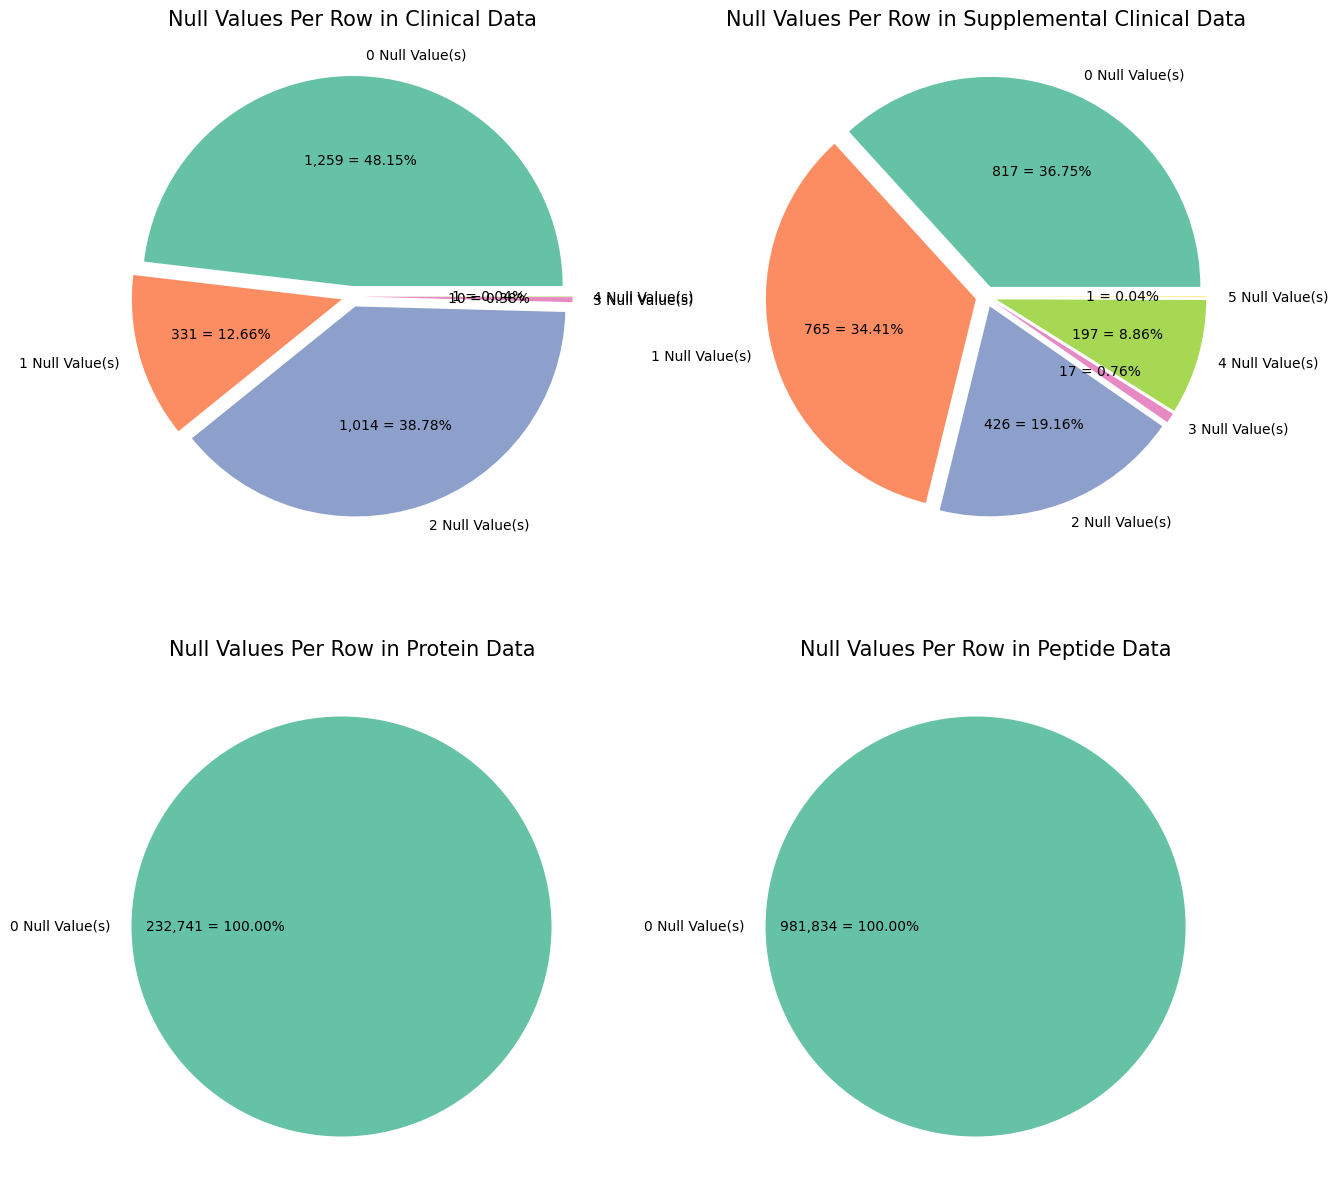

In [13]:
train_clinical_data["null_count"] = train_clinical_data.isnull().sum(axis=1)
counts_train_clinical_data = train_clinical_data.groupby("null_count")["visit_id"].count().to_dict()
null_train_clinical_data = {"{} Null Value(s)".format(k) : v for k, v in counts_train_clinical_data.items()}

train_peptides["null_count"] = train_peptides.isnull().sum(axis=1)
counts_train_peptides = train_peptides.groupby("null_count")["visit_id"].count().to_dict()
null_train_peptides = {"{} Null Value(s)".format(k) : v for k, v in counts_train_peptides.items()}

train_protiens["null_count"] = train_protiens.isnull().sum(axis=1)
counts_train_protiens = train_protiens.groupby("null_count")["visit_id"].count().to_dict()
null_train_protiens = {"{} Null Value(s)".format(k) : v for k, v in counts_train_protiens.items()}

supplemental_clinical_data["null_count"] = supplemental_clinical_data.isnull().sum(axis=1)
counts_supplemental_clinical_data = supplemental_clinical_data.groupby("null_count")["visit_id"].count().to_dict()
null_supplemental_clinical_data = {"{} Null Value(s)".format(k) : v for k, v in counts_supplemental_clinical_data.items()}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

axs = axs.flatten()

_ = axs[0].pie(
    x=list(null_train_clinical_data.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_train_clinical_data.values())/100, x),
    explode=[0.05] * len(null_train_clinical_data.keys()), 
    labels=null_train_clinical_data.keys(), 
    colors=sns.color_palette("Set2")[0:len(null_train_clinical_data.keys())],
)
_ = axs[0].set_title("Null Values Per Row in Clinical Data", fontsize=15)

_ = axs[3].pie(
    x=list(null_train_peptides.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_train_peptides.values())/100, x),
    explode=[0.05] * len(null_train_peptides.keys()), 
    labels=null_train_peptides.keys(), 
    colors=sns.color_palette("Set2")[0:len(null_train_peptides.keys())],
)
_ = axs[3].set_title("Null Values Per Row in Peptide Data", fontsize=15)

_ = axs[2].pie(
    x=list(null_train_protiens.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_train_protiens.values())/100, x),
    explode=[0.05] * len(null_train_protiens.keys()), 
    labels=null_train_protiens.keys(), 
    colors=sns.color_palette("Set2")[0:len(null_train_protiens.keys())],
)
_ = axs[2].set_title("Null Values Per Row in Protein Data", fontsize=15)

_ = axs[1].pie(
    x=list(null_supplemental_clinical_data.values()), 
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(null_supplemental_clinical_data.values())/100, x),
    explode=[0.05] * len(null_supplemental_clinical_data.keys()), 
    labels=null_supplemental_clinical_data.keys(), 
    colors=sns.color_palette("Set2")[0:len(null_supplemental_clinical_data.keys())],
)
_ = axs[1].set_title("Null Values Per Row in Supplemental Clinical Data", fontsize=15)

The good news is that we don't have any null values when it comes to CSF observations with the peptide and protein data. We do however see null values when it comes to the clinical data. Let's see what we are missing and why. We'll start with the clinical data.

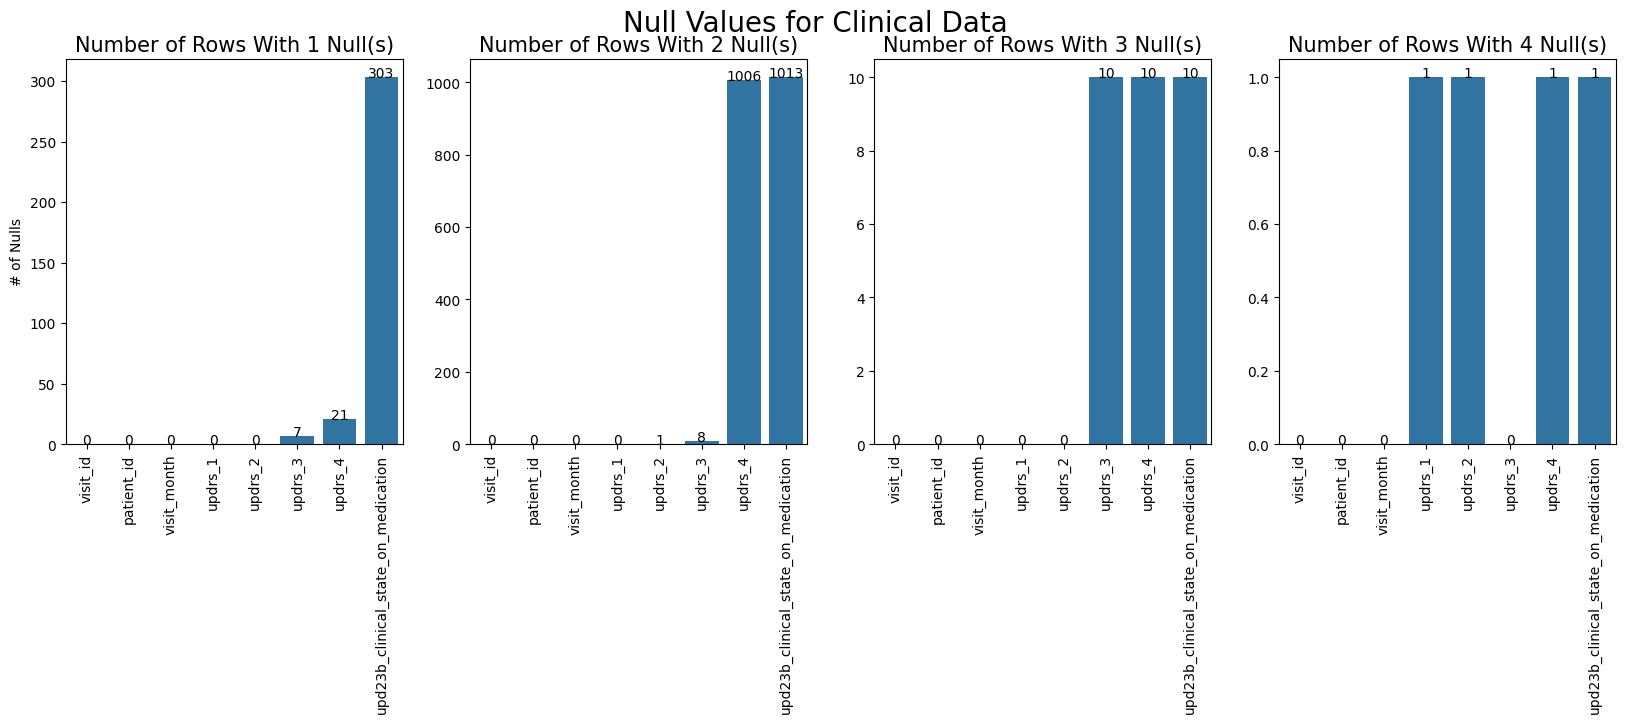

In [14]:
null_count_labels = [train_clinical_data[(train_clinical_data["null_count"] == x)].isnull().sum().index[:-1] for x in range(1, 6)]
null_count_values = [train_clinical_data[(train_clinical_data["null_count"] == x)].isnull().sum().values[:-1] for x in range(1, 6)]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("Null Values for Clinical Data", fontsize=20)

axs = axs.flatten()

for x in range(0, 4):
    ax = axs[x]
    labels = null_count_labels[x]
    _ = sns.barplot(x=labels, y=null_count_values[x], ax=ax)
    _ = ax.set_title("Number of Rows With {} Null(s)".format(x + 1), fontsize=15)
    _ = ax.set_ylabel("# of Nulls" if x == 0 else "")
    _ = ax.set_xlabel("")
    _ = ax.set_xticks([z for z in range(len(labels))], labels, rotation=90)
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x()+(p.get_width()/2), y=height, s="{:d}".format(int(height)), ha="center")

We are starting to see some interesting trends. Let's break this down by null counts.

### Rows with 1 Null Value

When there is a single null value in the row, it usually corresponds to the feature `upd23b_clinical_state_on_medication`. Valid responses are one of `On` or `Off`. Null values within the field are of interest, as it is uncertain whether they indicate that the patient was `Off` of medication, or if the assessment failed to capture the medication status of the patient. In the other two instances of null value counts, they occur 7 times in `updrs_3` and 21 times in `updrs_4`. According to Goetz et al (2008), part 3 of the UPDRS assessment concerns motor assessment, and has a minimum score of 0. Part 4 of the UPDRS assessment concerns motor complications, and again has a minimum score of 0. Null values in either of those columns suggest that the assessment was not performed. This is important, as a score of 0 indicates that the patient was assessed and was deemed to have normal responses. 

### Rows with 2 Null Values

When there are two null values in the row, they usually correspond to `updrs_4` and `upd23b_clinical_state_on_medication`. As mentioned previously, valid responses are `On` or `Off`, thus a null value here is of interest as we cannot be certain whether the assessment failed to capture medication status. The majority of the other null value fields occur with `updrs_4`, which concerns motor complications. Other null values occur infrequently in the `updrs_3`, and `updrs_2` fields. Again, UPDRS part 3 concerns motor assessment, and null values here cannot assumed to be 0 scores, given that 0 indicates normal function. With UPDRS part 2, the assessment concerns motor experiences of daily living, and again, null values here may indicate that the assessment was not performed. 

### Rows with 3 Null Values

There are 10 instances where rows contain 3 null values. In each instance, the row is missing information from `updrs_3`, `updrs_4`, and `upd23b_clinical_state_on_medication`. Again missing values cannot be assumed to be 0.

### Rows with 4 Null Values

Only a single instance of a row with 4 null values occurs. It appears that only the UPDRS part 3 assessment was performed at the visit. Again, null values cannot be interpreted as being 0, given that 0 based scores indicate a normal response. 

We need to also look at the supplemental information for null values.

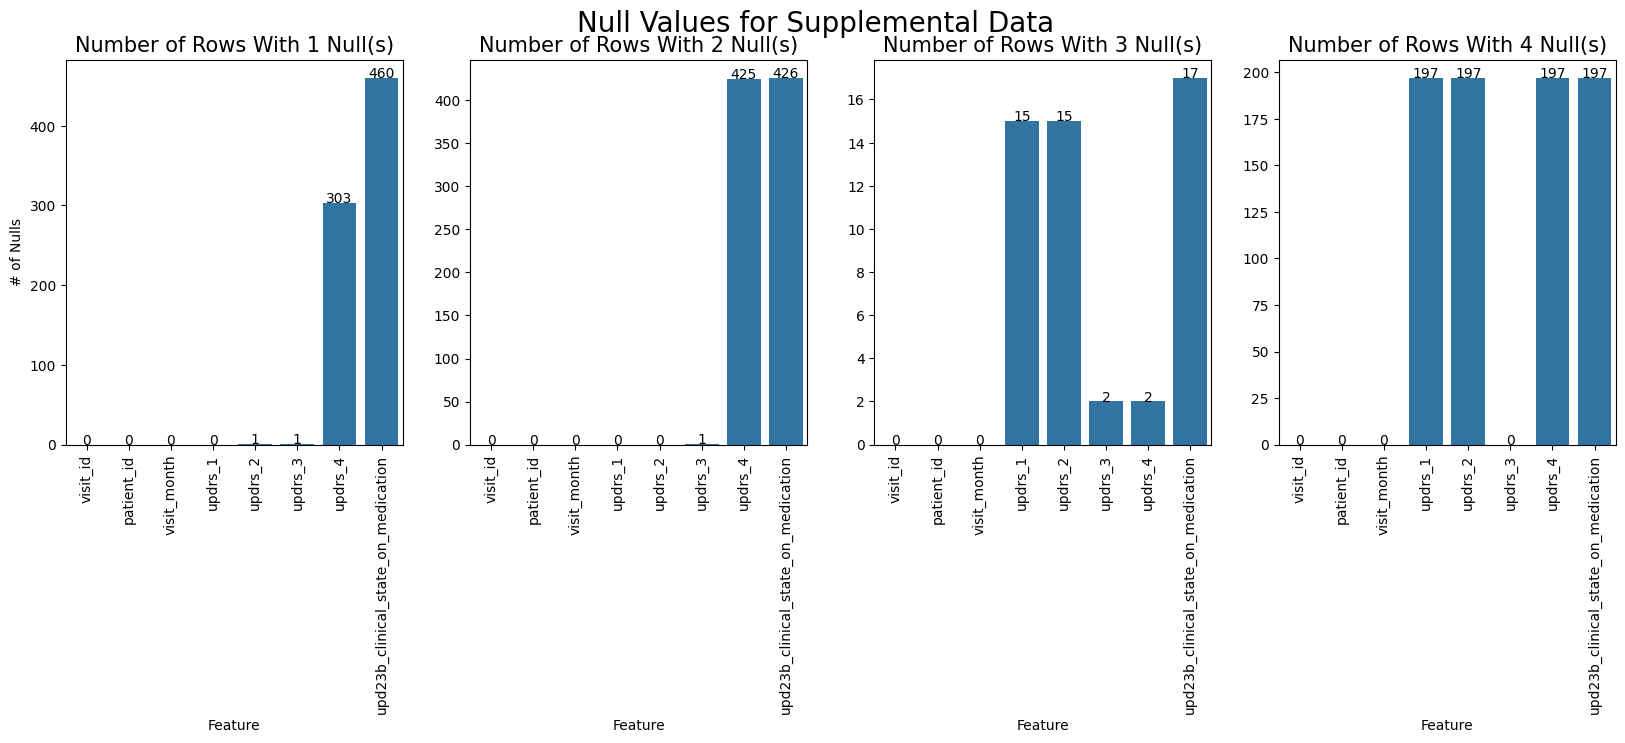

In [15]:
null_count_labels = [supplemental_clinical_data[(supplemental_clinical_data["null_count"] == x)].isnull().sum().index[:-1] for x in range(1, 6)]
null_count_values = [supplemental_clinical_data[(supplemental_clinical_data["null_count"] == x)].isnull().sum().values[:-1] for x in range(1, 6)]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("Null Values for Supplemental Data", fontsize=20)

axs = axs.flatten()

for x in range(0, 4):
    ax = axs[x]
    labels = null_count_labels[x]
    _ = sns.barplot(x=labels, y=null_count_values[x], ax=ax)
    _ = ax.set_title("Number of Rows With {} Null(s)".format(x + 1), fontsize=15)
    _ = ax.set_ylabel("# of Nulls" if x == 0 else "")
    _ = ax.set_xlabel("Feature")
    _ = ax.set_xticks([z for z in range(len(labels))], labels, rotation=90)
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x()+(p.get_width()/2), y=height, s="{:d}".format(int(height)), ha="center")

Again, similar patterns emerge. When there is a single null value in a row, it either appears in `updrs_4` and `upd23b_clinical_state_on_medication`. The same trend continues when there are two null values. When there are three null values, the trend differs slightly from the clinical data. In this case, the supplemental data is more likely to be missing `updrs_1` and `updrs_2` when compared to the clinical data. Finally, when there are four missing values, we see the same missing values in `updrs_1`, `updrs_2`, `updrs_4` and `upd23b_clinical_state_on_medication`. There is a significantly higher number of 4 null value rows in the supplemental data than in the clinical data.

### Key Observations About Null Values

* No null values are missing from peptide and protein data.
* Null values occur in the clinical data and supplemental data. General trends are:
    * Single null values occur most frequently in the `updrs_4` and `upd23b_clinical_state_on_medication` features.
    * Two null values occur most frequently in the `updrs_4` and `upd23b_clinical_state_on_medication` features.
    * Three null values occur most frequently in the:
        * `updrs_3`, `updrs_4`, and `upd23b_clinical_state_on_medication` features for the clinical data.
        * `updrs_1`, `updrs_2`, and `upd23b_clinical_state_on_medication` features for the supplemental data.
    * Four null values occur most frequently in the `updrs_1`, `updrs_2`, `updrs_4`, and `upd23b_clinical_state_on_medication` features.
* The supplemental data has many more examples of rows with four null values when compared to the clinical data.
* Care must be taken when dealing with null values:
    * It is not apparent whether the null values should be used to indicate a missed assessment, or whether they can be set to another value.
        * For UPDRS assessments, it may be erroneous to set the value to 0 as that would indicate a "normal" result.
        * For the `upd23b_clinical_state_on_medication` feature, the only valid settings are `On` or `Off`, thus the impact of null is undefined.

# 1.3 - Duplicated Rows

We should next check to see if we have any duplicated values in our various datasets. Duplicates may impact our learning methods, resulting in prediction bias toward the duplicate information. 

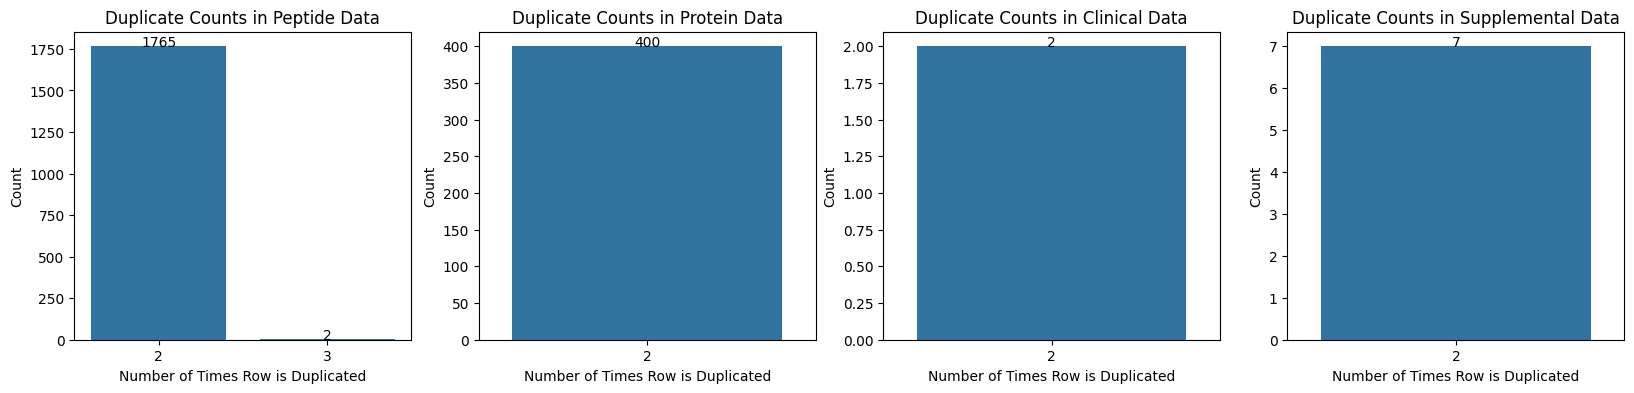

In [16]:
titles = ["Peptide Data", "Protein Data", "Clinical Data", "Supplemental Data"]
value_counts = []
duplicates = train_peptides.pivot_table(index=[
    'UniProt', 'Peptide', 'PeptideAbundance',
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts.append(dict(zip(unique, counts)))

duplicates = train_protiens.pivot_table(index=[
    'UniProt', 'NPX',
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts.append(dict(zip(unique, counts)))

duplicates = train_clinical_data.pivot_table(index=[
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts.append(dict(zip(unique, counts)))

duplicates = supplemental_clinical_data.pivot_table(index=[
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'
], aggfunc="size")
unique, counts = np.unique(duplicates, return_counts=True)
value_counts.append(dict(zip(unique, counts)))

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

axs = axs.flatten()

for x in range(4):
    ax = axs[x]
    _ = sns.barplot(x=list(value_counts[x].keys())[1:], y=list(value_counts[x].values())[1:], ax=ax)
    _ = ax.set_title("Duplicate Counts in {}".format(titles[x], fontsize=15))
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("Number of Times Row is Duplicated")
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x()+(p.get_width()/2), y=height, s="{:d}".format(int(height)), ha="center")

### Key Observations About Duplicated Rows

* In terms of data/raw duplicates:
    * In the clinical data:
        * There are 2 instances where the same row of data appears twice.
        * Duplicates account for 0.15% of all clinical data.
    * In the supplemental data:
        * There are 7 instances where the same row of data appears twice.
        * Duplicates account for 0.63% of all supplemental data.
    * In the protein data:
        * There are 400 instances where the same row of data appears twice.
        * Duplicates account for 0.35% of all protein data.
    * In the peptide data:
        * There are 1,765 instances where the same row of data appears twice.
        * There are 2 instances where the same row of data appears 3 times.
        * Duplicates account for 0.36% of all peptide data.
* Overall, with the clinical and supplemental data, duplicates are likely to have little or no impact.

# 1.4 - Statistical Breakdown

Let's take a closer look at some of the statistical properties of the continuous features. 

## 1.4.1 - Clinical vs Supplemental Data

To begin, let's compare the clinical data to the supplemental data to see what kind of differences we have.

### Clinical Data

In [17]:
features = [
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
]

train_clinical_data[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
visit_month,2615.000000,31.190822,25.199053,0.000000,10.500000,24.000000,48.000000,108.000000
updrs_1,2614.000000,7.110559,5.525955,0.000000,3.000000,6.000000,10.000000,33.000000
updrs_2,2613.000000,6.743590,6.323230,0.000000,1.000000,5.000000,10.000000,40.000000
updrs_3,2590.000000,19.421236,15.000289,0.000000,6.000000,19.000000,29.000000,86.000000
updrs_4,1577.000000,1.861763,3.022112,0.000000,0.000000,0.000000,3.000000,20.000000


### Supplemental Data

In [18]:
features = [
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
]

supplemental_clinical_data[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
visit_month,2223.000000,12.910481,13.060532,0.000000,0.000000,6.000000,24.000000,36.000000
updrs_1,2010.000000,5.684080,4.366964,0.000000,2.000000,5.000000,8.000000,27.000000
updrs_2,2009.000000,6.507715,4.968132,0.000000,2.000000,5.000000,10.000000,34.000000
updrs_3,2218.000000,22.917944,12.342596,0.000000,14.000000,22.000000,31.000000,72.000000
updrs_4,1295.000000,0.840154,1.860247,0.000000,0.000000,0.000000,0.000000,12.000000


Supplemental data appears to have visits that occur mainly between 0 and 36 months, while clinical data shows visits occurring between 0 and 108 months. We can confirm this by looking at kernel density estimates for the months of the various visits.

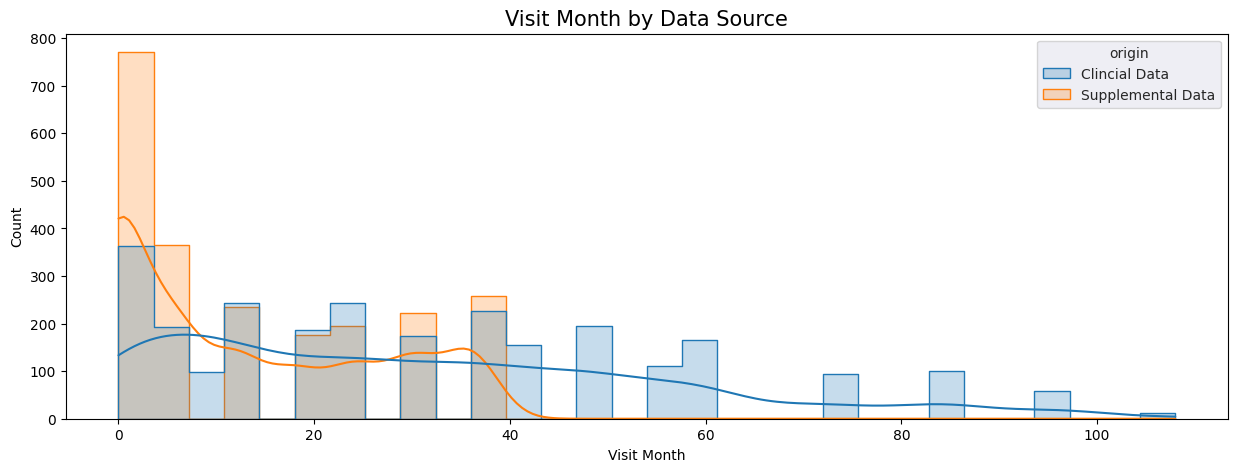

In [19]:
train_clinical_data["origin"] = "Clincial Data"
supplemental_clinical_data["origin"] = "Supplemental Data"

combined = pd.concat([train_clinical_data, supplemental_clinical_data]).reset_index(drop=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')

_ = sns.histplot(data=combined, x="visit_month", hue="origin", kde=True, ax=ax, element="step")
_ = ax.set_title("Visit Month by Data Source", fontsize=15)
_ = ax.set_ylabel("Count")
_ = ax.set_xlabel("Visit Month")

As we can see, the supplemental data is focused around 0 month visits, and ends at 36 months, while the clinical data spans a much longer time-frame. We can also do a quick visual check to see if there are differences between the clinical and supplemental data when it comes to UPDRS scores. For the figures below, the trend lines are kernel density estimates, thus differences in data/raw counts are taken into consideration with the trend lines.

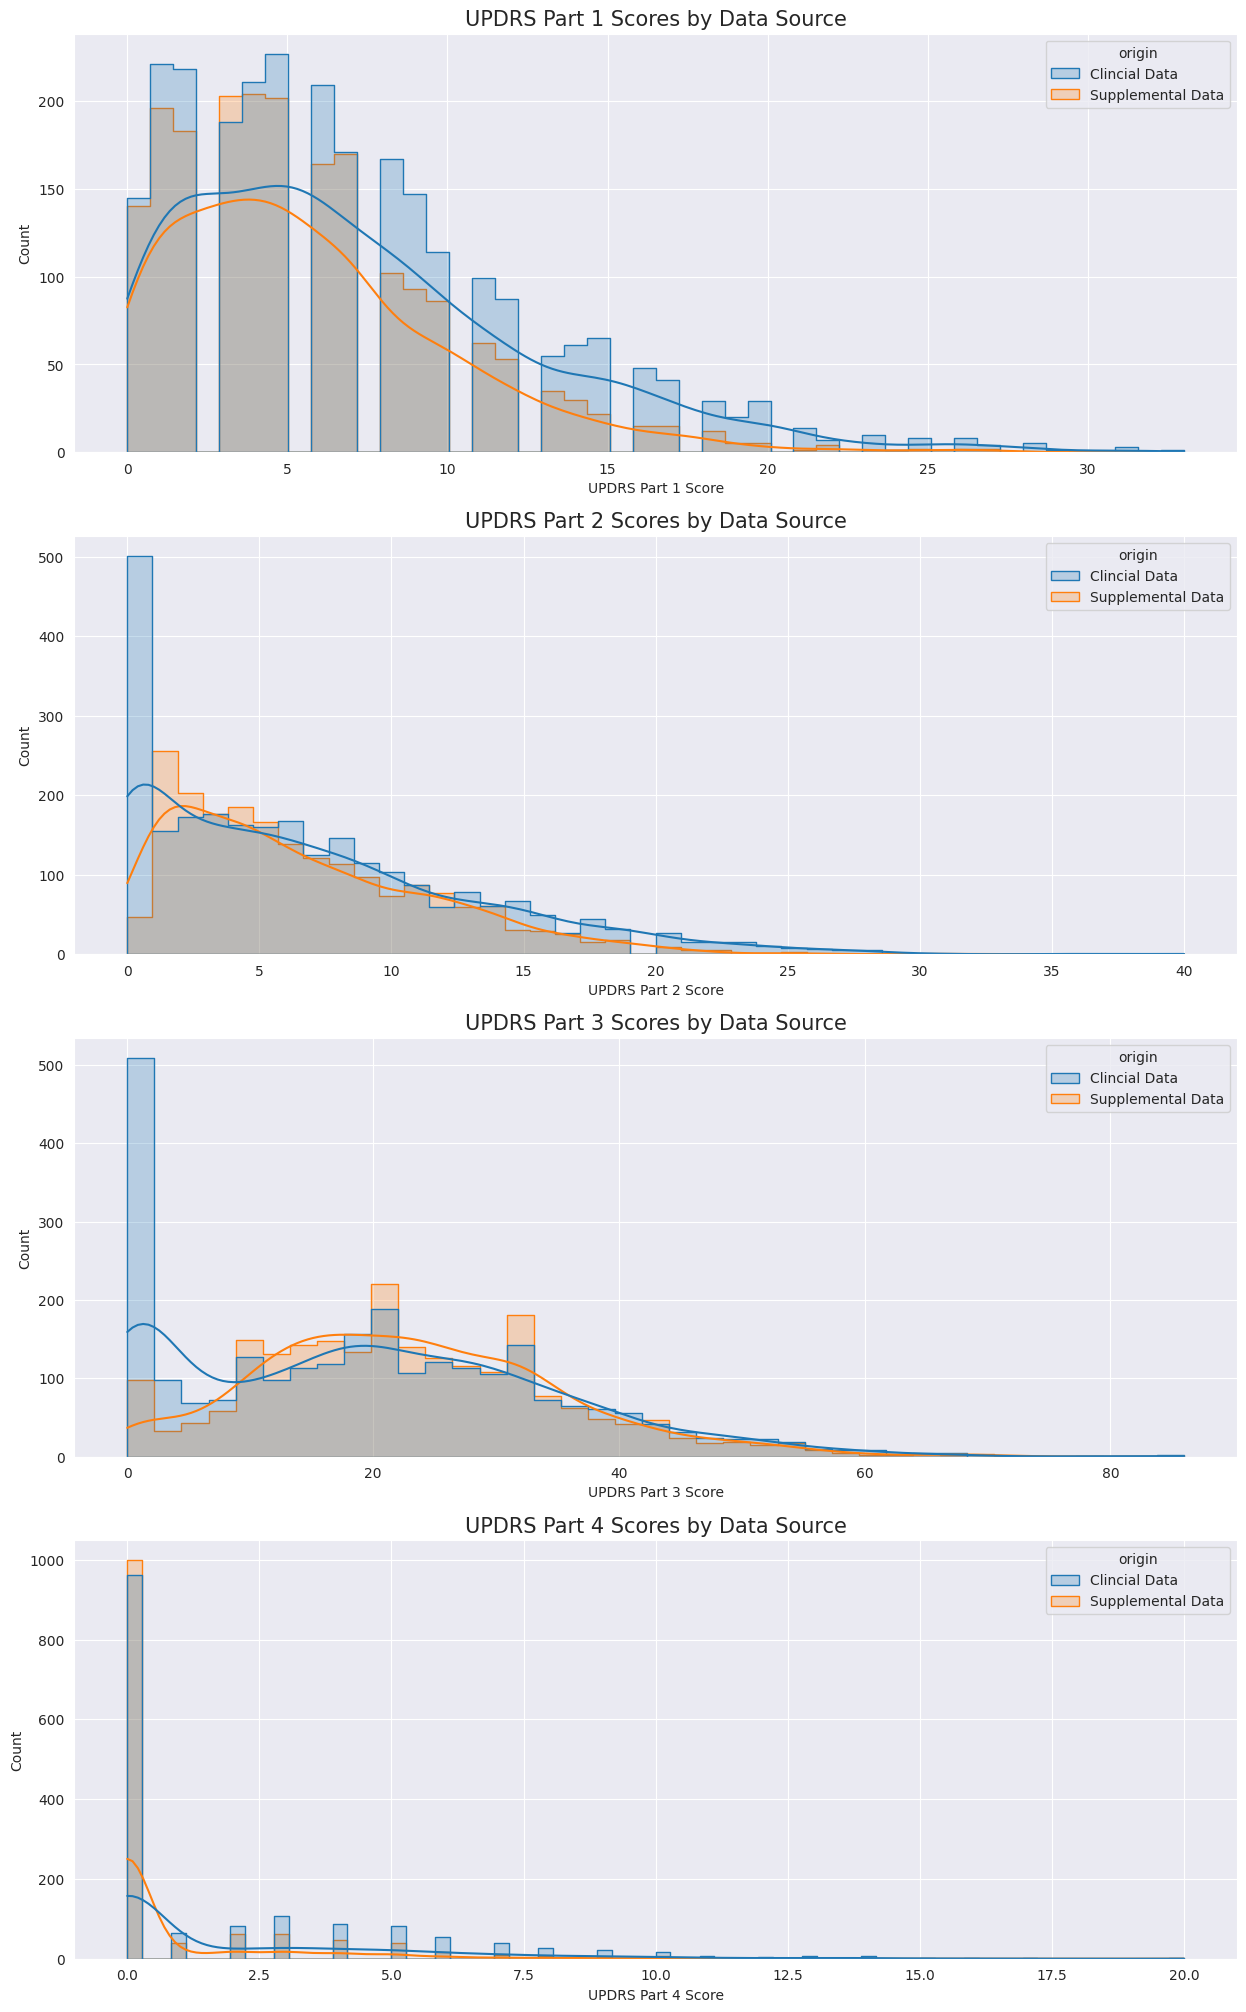

In [20]:
train_clinical_data["origin"] = "Clincial Data"
supplemental_clinical_data["origin"] = "Supplemental Data"

combined = pd.concat([train_clinical_data, supplemental_clinical_data]).reset_index(drop=True)

features = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
labels = ["UPDRS Part 1", "UPDRS Part 2", "UPDRS Part 3", "UPDRS Part 4"]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.set_style('darkgrid')

axs = axs.flatten()

sns.set_style('darkgrid')

for x, feature in enumerate(features):
    ax = axs[x]
    _ = sns.histplot(data=combined, x=feature, hue="origin", kde=True, ax=ax, element="step")
    _ = ax.set_title("{} Scores by Data Source".format(labels[x]), fontsize=15)
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("{} Score".format(labels[x]))

There are a few interesting observations:

* UPDRS Part 1 and 4 scores appear to be fairly similar in their distribution between the clinical and supplemental data sources.
* UPDRS Part 2 and 3 scores have a much higher proportion of 0 based scores in the clinical data when compared to the supplemental data source.

As a final check, we can get a rough measure of the differences between the clinical data and supplemental data by performing an adversarial validation. The goal with adversarial validation is to see if a classifier can tell the two datasets apart. We'll use ROC AUC score to inform us of differences. If the two sets appear to be very similar, the classifier will not be able to tell them apart, and thus will have an ROC AUC score of 0.5. If they are easy to tell apart - and thus are very dissimilar - then the ROC AUC score will approach 1. 

-------> Fold 1 <--------
: AUC ROC = 0.93284295239891
-------> Fold 2 <--------
: AUC ROC = 0.9443979556368038
-------> Fold 3 <--------
: AUC ROC = 0.927000150024647
-------> Fold 4 <--------
: AUC ROC = 0.9435134052227236
-------> Fold 5 <--------
: AUC ROC = 0.9532604768786127
--> Overall results for out of fold predictions
: AUC ROC = 0.9389806206451068


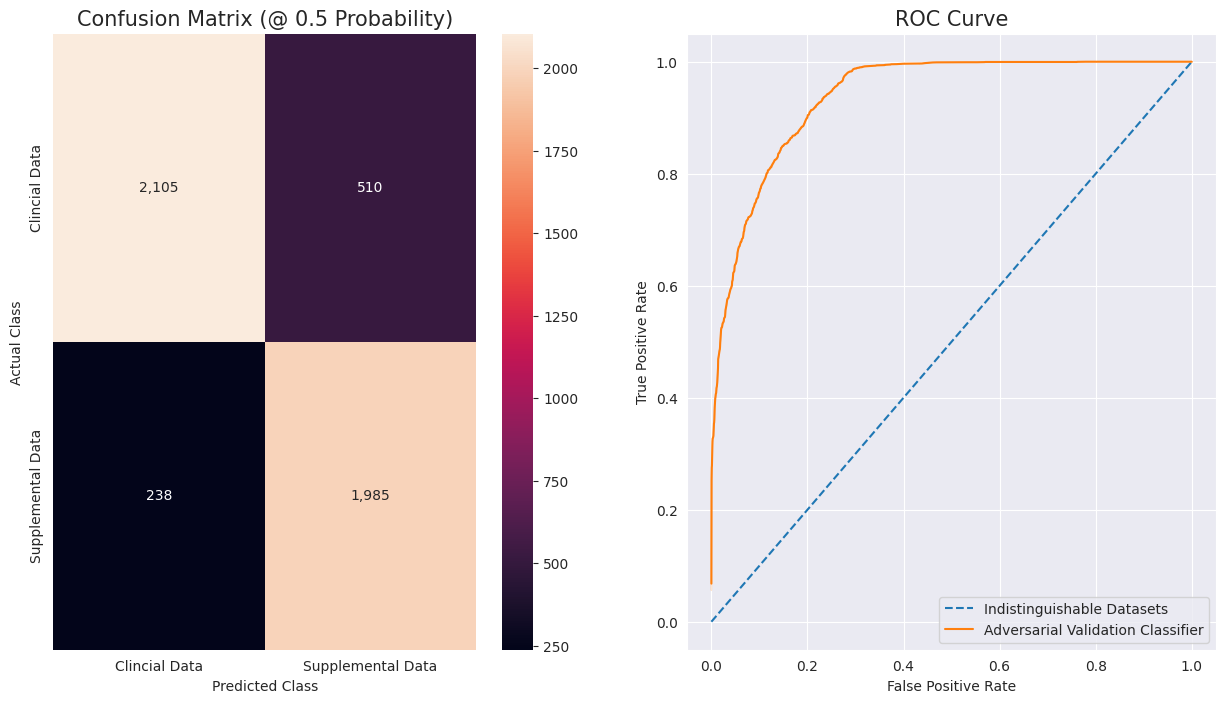

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

train_clinical_data["origin"] = 0
supplemental_clinical_data["origin"] = 1

combined = pd.concat([train_clinical_data, supplemental_clinical_data]).reset_index(drop=True)

features = [
    'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication',
]

le = LabelEncoder()
combined['upd23b_clinical_state_on_medication'] = le.fit_transform(combined['upd23b_clinical_state_on_medication'])
    
n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((combined.shape[0],))
train_oof_probas = np.zeros((combined.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(combined, combined["origin"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(combined.iloc[train_index]), pd.DataFrame(combined.iloc[test_index])
    y_train, y_valid = combined["origin"].iloc[train_index], combined["origin"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,  
        max_depth=3,
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_probas = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(": AUC ROC = {}".format(roc_auc_score(y_valid, oof_probas)))
    
auc_vanilla = roc_auc_score(combined["origin"], train_oof_probas)
fpr, tpr, _ = roc_curve(combined["origin"], train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

confusion = confusion_matrix(combined["origin"], train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

labels = ["Clincial Data", "Supplemental Data"]

_ = sns.heatmap(confusion, annot=True, fmt=",d", ax=axs[0], xticklabels=labels, yticklabels=labels)
_ = axs[0].set_title("Confusion Matrix (@ 0.5 Probability)", fontsize=15)
_ = axs[0].set_ylabel("Actual Class")
_ = axs[0].set_xlabel("Predicted Class")

_ = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
_ = sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
_ = axs[1].set_title("ROC Curve", fontsize=15)
_ = axs[1].set_xlabel("False Positive Rate")
_ = axs[1].set_ylabel("True Positive Rate")

With an AUC ROC score of 0.939, we can see that the classifier can easily tell the two datasets apart. This suggests that they are very dissimilar in nature, as was indicated as part of the competition. Caution should be used when mixing these two datasets, as they are very different in nature.

## 1.4.2 - Protein Data

Let's take a look at the values we have for protein data.

In [22]:
train_protiens[["NPX"]].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
NPX,232741.000000,2712076.943823,22241547.317363,84.608200,29464.400000,113556.000000,563894.000000,613851000.000000


Protein expression frequency values appear to have a wide range of values. We'll use a quick kernel density estimate to get an idea of where frequencies are clustered. We'll use a logarithmic scale due to the large values and potential variability involved in the expression frequencies.

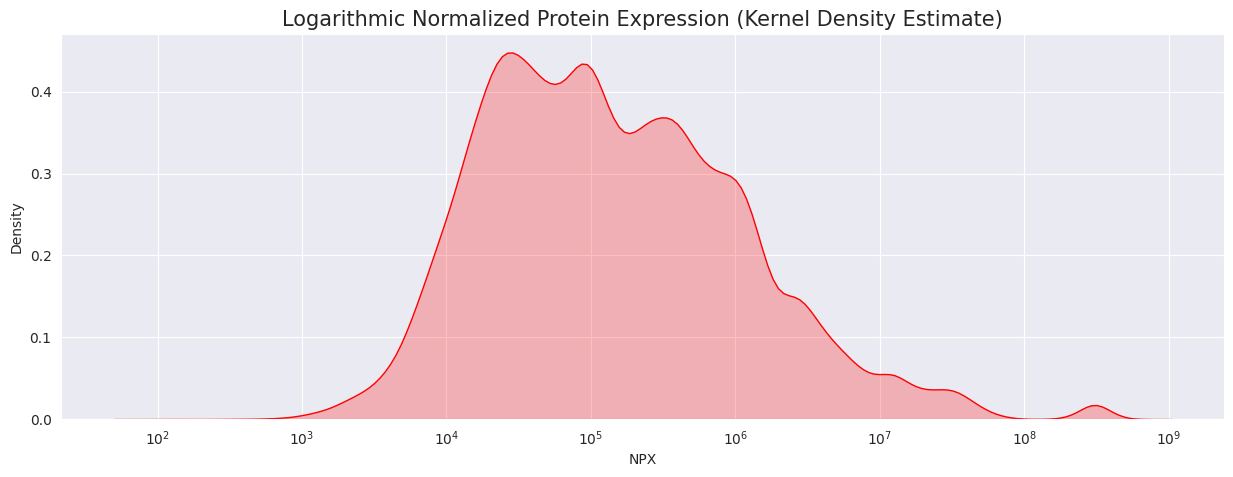

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')

_ = sns.kdeplot(train_protiens["NPX"], shade=True, color="r", ax=ax, label="Normalized Protein Expression", log_scale=True)
_ = ax.set_title("Logarithmic Normalized Protein Expression (Kernel Density Estimate)", fontsize=15)

As we can see, there is a lot of variability regarding the actual protein expression frequencies. We'll look more into the distribution of various proteins and their association to the UPDRS scores in section 2 below. For now, the key observation we have is that normalized protein expression is highly variable, as indicated by the min, max, and standard deviation of the feature.

## 1.4.3 - Peptide Data

Let's take a look at what we have for the peptide data.

In [24]:
train_peptides[["PeptideAbundance"]].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
PeptideAbundance,981834.000000,642890.245933,3377989.092586,10.998500,28174.250000,74308.300000,221338.750000,178752000.000000


Again, we see a wide variation in the abundance of peptides. The min, max, and standard deviation tell us that peptide abundances will likely vary greatly depending on the particular peptide we are looking at. Again, we can plot kernel density estimates to give us an idea of where the bulk of our values exist.

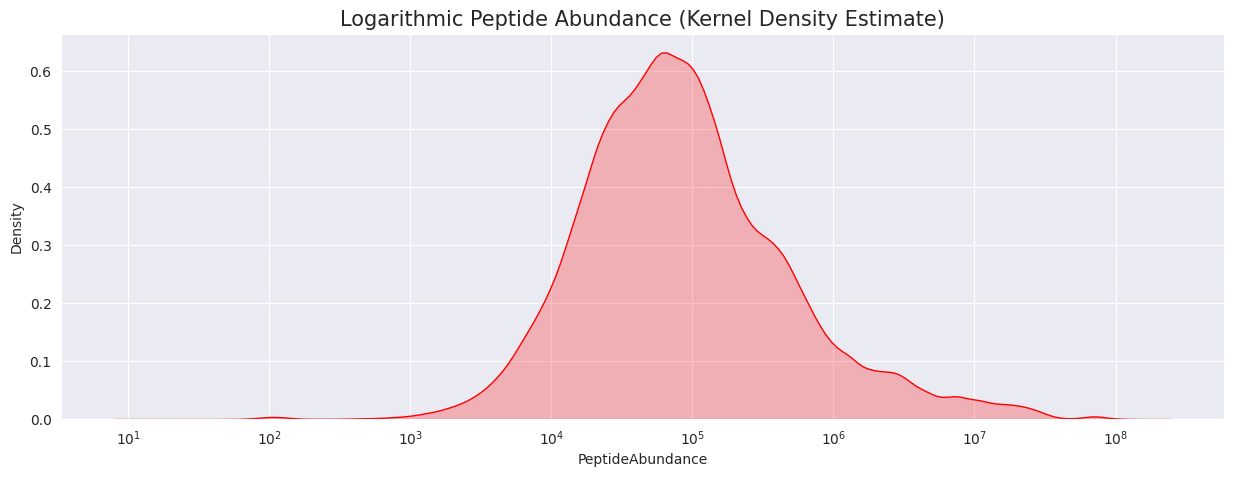

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')

_ = sns.kdeplot(train_peptides["PeptideAbundance"], shade=True, color="r", ax=ax, label="Peptide Abundance", log_scale=True)
_ = ax.set_title("Logarithmic Peptide Abundance (Kernel Density Estimate)", fontsize=15)

Once again, we'll look at peptide data - specifically peptide sequences and how they relate to UPDRS scores - in section 2 below.

### Key Observations About Statistical Breakdown

* The clinical data and supplementary data have very different month ranges:
    * This was confirmed by looking at their statistical properties, histograms, and adversarial validation.
* Protein expression data has a wide range of values, and thus will need to be further broken down into sub-groupings to be informative.
* Peptide abundance frequencies has a wide range of values, and thus will need to be further broken down into sub-groupings to be informative.

# 2 - Feature Exploration

In this section, we will examine each of the features we have to work with in more detail.

# 2.1 - Visit Month

The visit month has an impact across all of the different datasets, and subsequently, through many different features that we have. Let's take a look at them in turn.

# 2.1.1 - Visit Month vs UPDRS 

For each visit month, we have observations about the target features - UPDRS scores. According to Holden et al (2018), the findings in each part of the UPDRS were dependent on whether or not the patient was taking medication. We should sub-divide the UPDRS score observations into groups that were taking medication, and those that were not. For the purposes of this exploration, a null value found in clinical data regarding medication state will be considered to be `Off`.

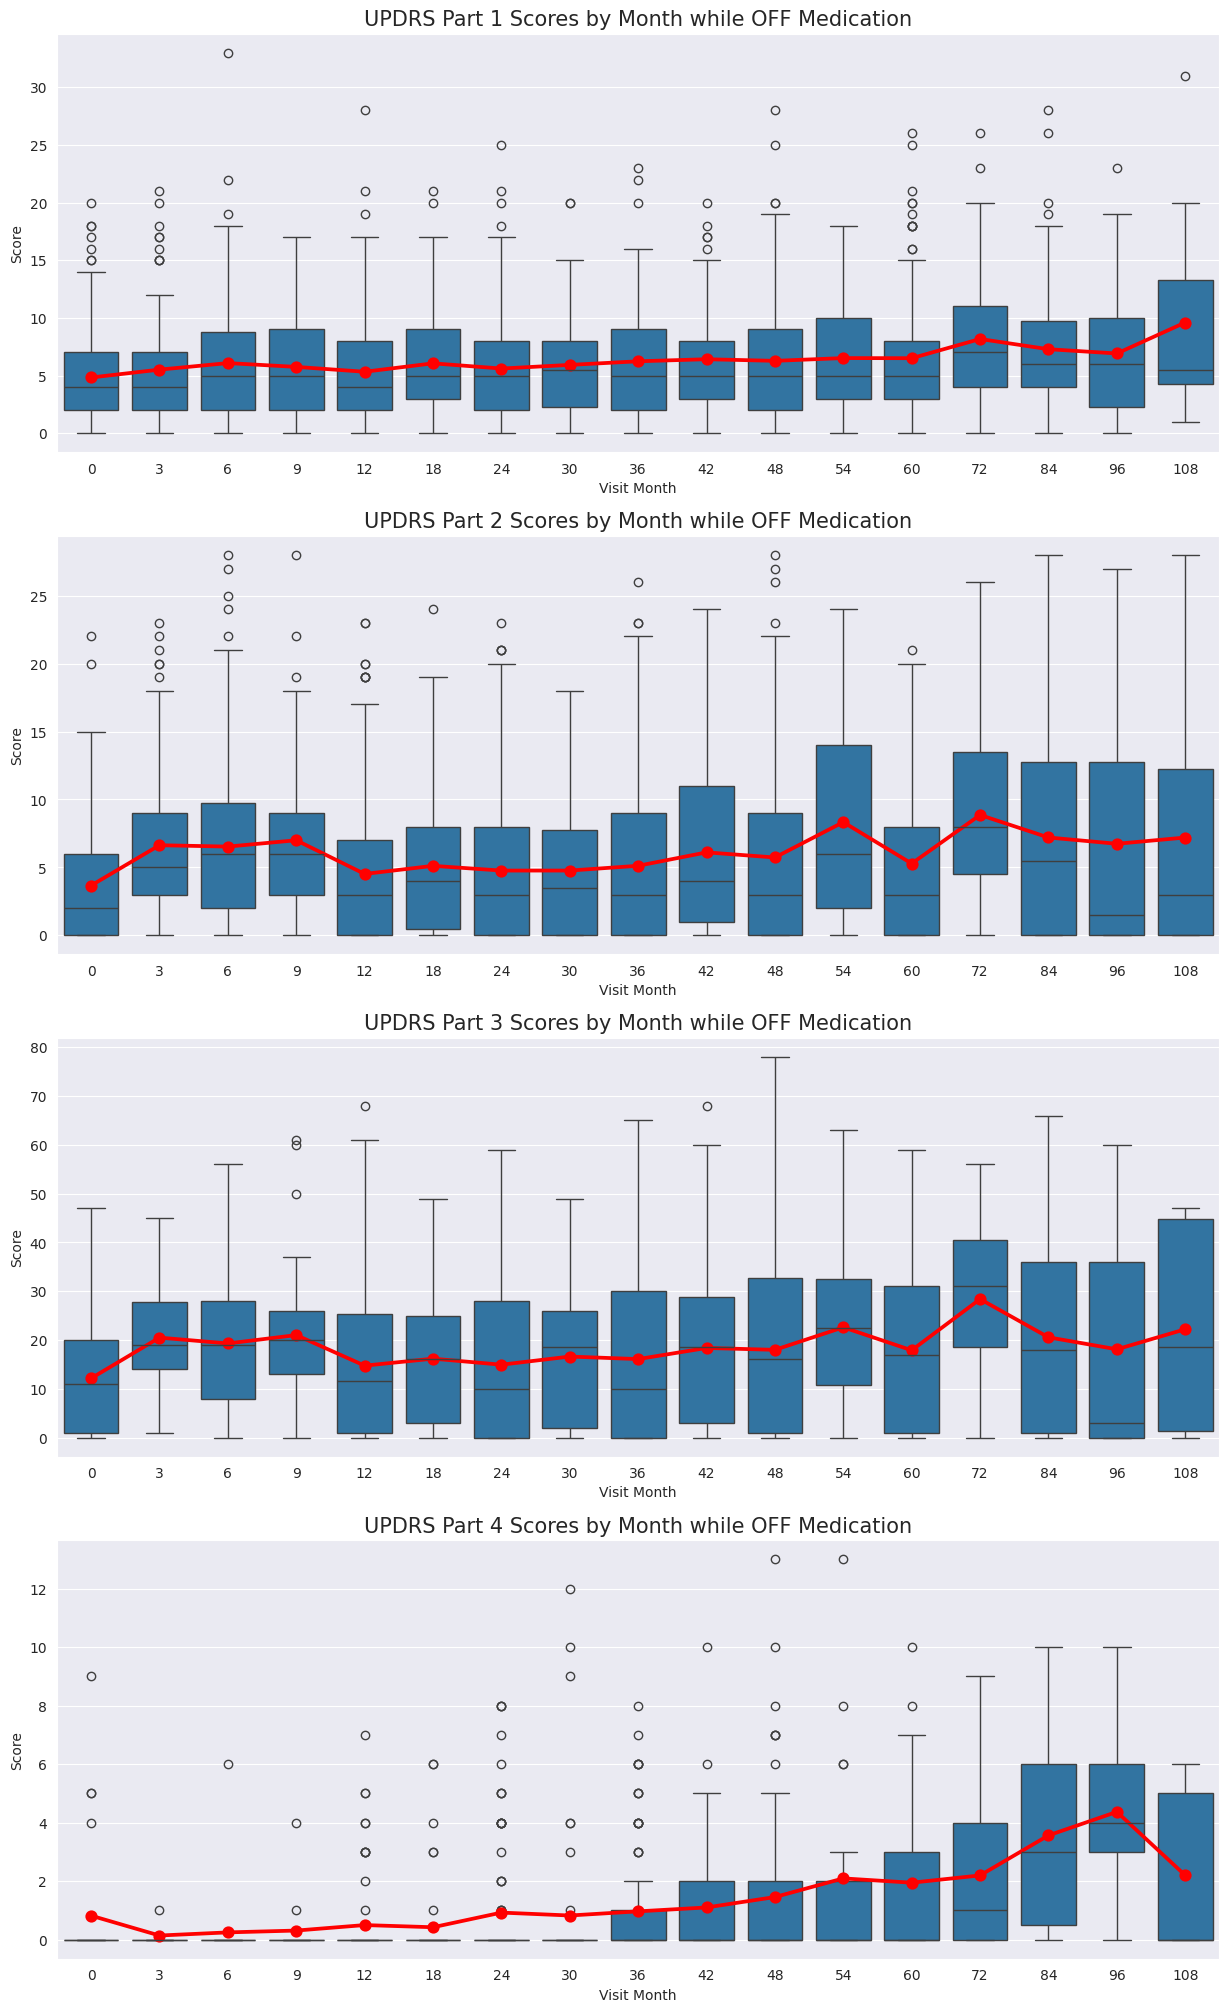

In [27]:
train_clincial_data_copy = train_clinical_data.copy()
train_clincial_data_copy["upd23b_clinical_state_on_medication"] = train_clincial_data_copy["upd23b_clinical_state_on_medication"].fillna("Off")

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.set_style('darkgrid')

axs = axs.flatten()

for x, feature in enumerate(["updrs_1", "updrs_2", "updrs_3", "updrs_4"]):
    ax = axs[x]
    data = train_clincial_data_copy[(train_clincial_data_copy["upd23b_clinical_state_on_medication"] == "Off")]
    _ = sns.boxplot(data=data, x="visit_month", y=feature, ax=ax)
    _ = sns.pointplot(data=data, x="visit_month", y=feature, color="r", ci=None, ax=ax)
    _ = ax.set_title("UPDRS Part {} Scores by Month while OFF Medication".format(x+1), fontsize=15)
    _ = ax.set_xlabel("Visit Month")
    _ = ax.set_ylabel("Score")

Some general observations when OFF medication:
    
* There is a large amount of variance and outliers across each of the UPDRS parts and their respective visit months.
* In general across UPDRS Parts 1 - 3, the trendline of score remains relatively flat.
    * With UPDRS Part 4, we see a gradual increase in score.

ValueError: Unrecognized linestyle: [':']

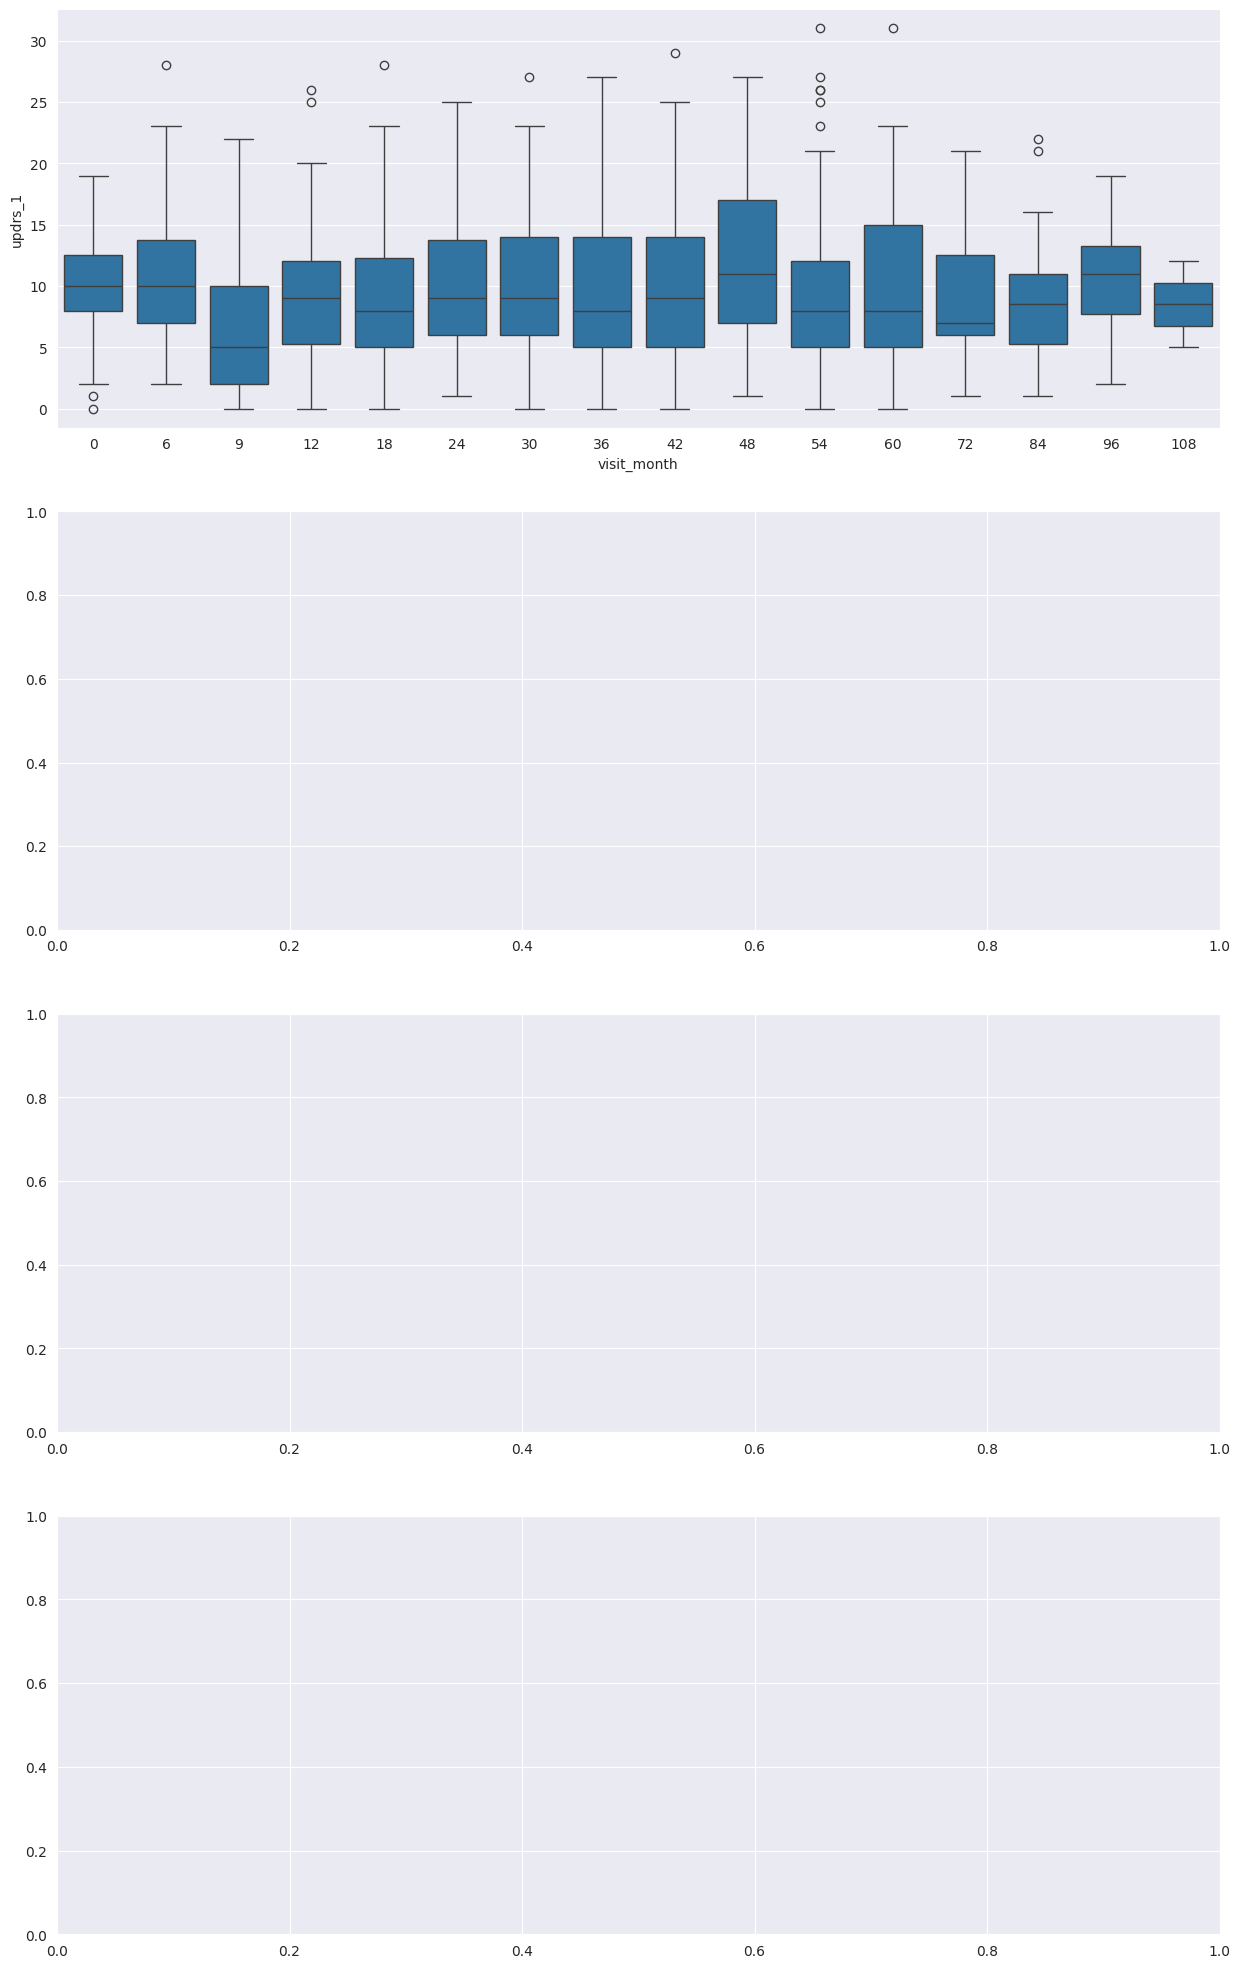

In [28]:
train_clincial_data_copy = train_clinical_data.copy()
train_clincial_data_copy["upd23b_clinical_state_on_medication"] = train_clincial_data_copy["upd23b_clinical_state_on_medication"].fillna("Off")

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.set_style('darkgrid')

axs = axs.flatten()

for x, feature in enumerate(["updrs_1", "updrs_2", "updrs_3", "updrs_4"]):
    ax = axs[x]
    data = train_clincial_data_copy[(train_clincial_data_copy["upd23b_clinical_state_on_medication"] == "On")]
    _ = sns.boxplot(data=data, x="visit_month", y=feature, ax=ax)
    _ = sns.pointplot(data=data, x="visit_month", y=feature, color="r", ci=None, linestyles=[":"], ax=ax)
    _ = ax.set_title("UPDRS Part {} Scores by Month while ON Medication".format(x+1), fontsize=15)
    _ = ax.set_xlabel("Visit Month")
    _ = ax.set_ylabel("Score")

Some general observations when ON medication:
    
* There is a large amount of variance and outliers across each of the UPDRS parts and their respective visit months.
* In general across UPDRS Parts 1, 2, and 4, the trendline of score remains relatively flat.
    * With UPDRS Part 3, we see a gradual increase in score.

As mentioned by Holden et al (2018), the maximum score of the UPDRS is 272. In prior versions of the UPDRS, there was a linear progression of UPDRS score as time progressed. We should look at the sum total of the UPDRS scores to see if there is a score increase over time within this data.

ValueError: Unrecognized linestyle: [':']

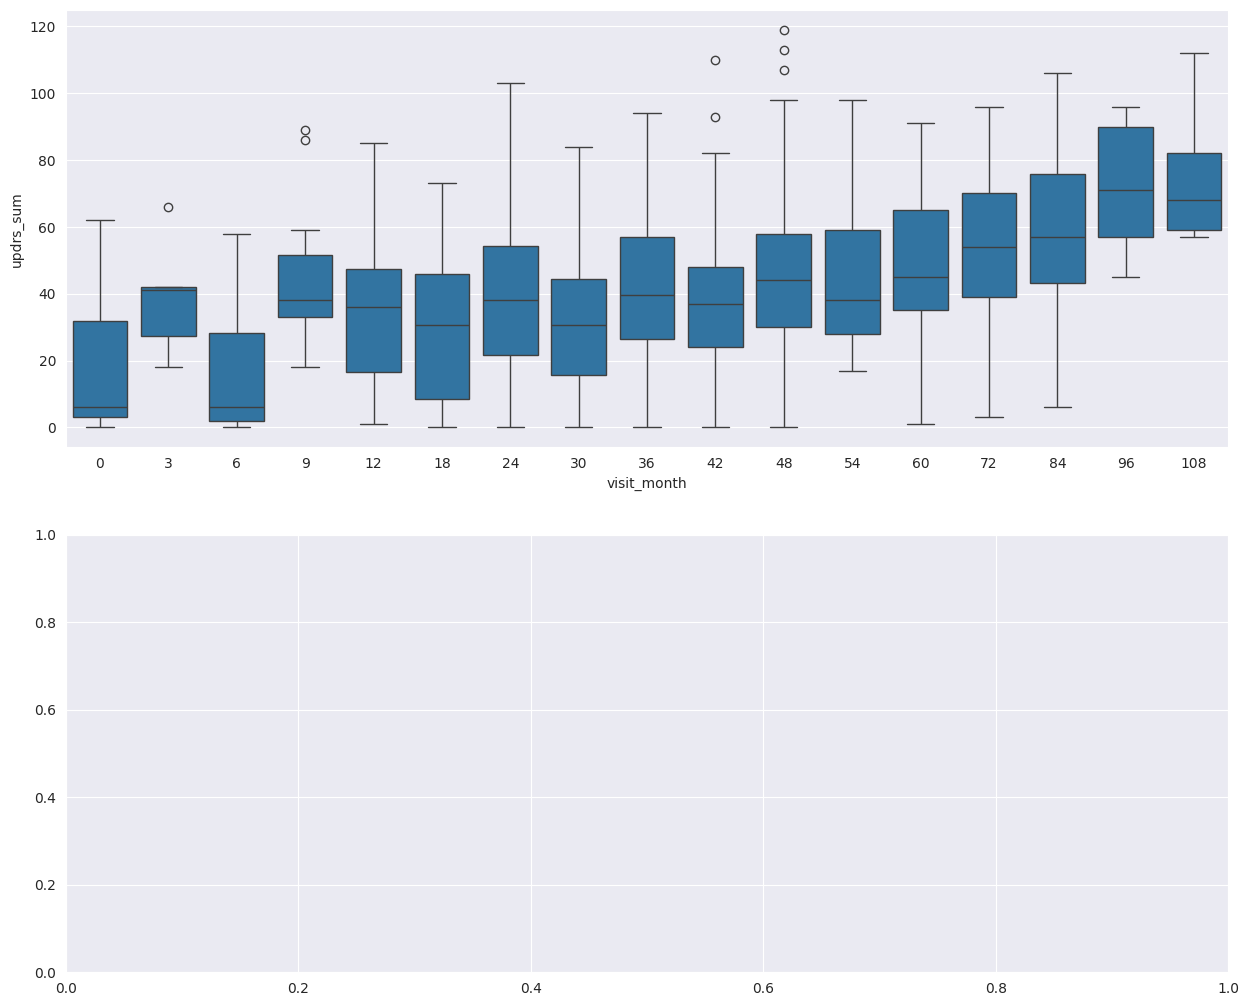

In [29]:
train_clinical_data["updrs_sum"] = train_clinical_data["updrs_1"] + train_clinical_data["updrs_2"] + train_clinical_data["updrs_3"] + train_clinical_data["updrs_4"]
train_clincial_data_copy = train_clinical_data.copy()
train_clincial_data_copy["upd23b_clinical_state_on_medication"] = train_clincial_data_copy["upd23b_clinical_state_on_medication"].fillna("Off")

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 12.5))

axs = axs.flatten()

sns.set_style('darkgrid')

data = train_clincial_data_copy[(train_clincial_data_copy["upd23b_clinical_state_on_medication"] == "Off")]
ax = axs[0]
_ = sns.boxplot(data=data, x="visit_month", y="updrs_sum", ax=ax)
_ = sns.pointplot(data=data, x="visit_month", y="updrs_sum", color="r", ci=None, linestyles=[":"], ax=ax)
_ = ax.set_title("UPDRS Sum of Scores by Month while OFF Medication".format(x+1), fontsize=15)
_ = ax.set_xlabel("Visit Month")
_ = ax.set_ylabel("Score")

data = train_clincial_data_copy[(train_clincial_data_copy["upd23b_clinical_state_on_medication"] == "On")]
ax = axs[1]
_ = sns.boxplot(data=data, x="visit_month", y="updrs_sum", ax=ax)
_ = sns.pointplot(data=data, x="visit_month", y="updrs_sum", color="r", ci=None, linestyles=[":"], ax=ax)
_ = ax.set_title("UPDRS Sum of Scores by Month while ON Medication".format(x+1), fontsize=15)
_ = ax.set_xlabel("Visit Month")
_ = ax.set_ylabel("Score")

With the sum of all UPDRS scores while OFF medication, we see an upwards trend as the visit month increases, which indicates that overall, disease progression is occurring. While ON medication, the trendline remains relatively flat until months > 96, which sees an increase in overall score. Again, this indicates that disease progression is occurring. If we combine both ON and OFF medication status:

In [ ]:
train_clinical_data["updrs_sum"] = train_clinical_data["updrs_1"] + train_clinical_data["updrs_2"] + train_clinical_data["updrs_3"] + train_clinical_data["updrs_4"]
train_clincial_data_copy = train_clinical_data.copy()
train_clincial_data_copy["upd23b_clinical_state_on_medication"] = train_clincial_data_copy["upd23b_clinical_state_on_medication"].fillna("Off")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')

_ = sns.boxplot(data=train_clincial_data_copy, x="visit_month", y="updrs_sum", ax=ax)
_ = sns.pointplot(data=train_clincial_data_copy, x="visit_month", y="updrs_sum", color="r", ci=None, linestyles=[":"], ax=ax)
_ = ax.set_title("UPDRS Sum of Scores by Month", fontsize=15)
_ = ax.set_xlabel("Visit Month")
_ = ax.set_ylabel("Score")

Overall, we see a trend of increasing UPDRS scores. This observation is important, as it suggests that our scores should likely see increases as time progresses, rather than decreases. This can be used as a post-processing check to ensure predictions being made by our machine learning algorithms make sense.

# 2.1.2 - Visit Month vs Protein Data

Without diving too much into the actual protein data, we should check to see if there are general trends regarding the breakdown of protein data by month.

In [ ]:
train_protiens_copy = train_protiens.copy()
train_protiens_copy["log_NPX"] = np.log(train_protiens_copy["NPX"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')

_ = sns.boxplot(data=train_protiens_copy, x="visit_month", y="log_NPX", ax=ax)
_ = sns.pointplot(data=train_protiens_copy, x="visit_month", y="log_NPX", color="r", ci=None, linestyles=[":"], ax=ax)
_ = ax.set_title("NPX by Month", fontsize=15)
_ = ax.set_xlabel("Visit Month")
_ = ax.set_ylabel("NPX")

Unsurprisingly, we see stable amounts of protein expressions across each month category. There is a large amount of variance regarding the protein expression frequencies, but overall, we're seeing the same mean total NPX values repeated across the months. This likely means that there will be differences in the actual proteins expressed, rather than their absolute numbers. 

We can check to see if there are any significant increases or decreases in `UniProt` proteins across the months. Looking at all 227 proteins is going to be challenging. For this, we'll look at proteins that have significant increases or decreases across the months. We'll examine protein counts for all 227 proteins, and then pick out ones that appear to have very large standard deviations compared to their mean. For this EDA, we'll look at any protein expression data that has a standard deviation of more than 25% of the mean value.

In [30]:
unique_proteins = train_protiens["UniProt"].unique()
unique_months = train_protiens["visit_month"].unique()

protein_dict = dict()
for protein in unique_proteins:
    if protein not in protein_dict:
        protein_dict[protein] = {
            "months": unique_months,
            "count_NPX": [train_protiens[(train_protiens["UniProt"] == protein) & (train_protiens["visit_month"] == month)]["NPX"].count() for month in unique_months],
            "total_NPX": [train_protiens[(train_protiens["UniProt"] == protein) & (train_protiens["visit_month"] == month)]["NPX"].sum() for month in unique_months],
            "avg_NPX": [0 * len(unique_months)],
        }
        
for protein in unique_proteins:
    protein_dict[protein]["avg_NPX"] = [float(total) / count for total, count in zip(protein_dict[protein]["total_NPX"], protein_dict[protein]["count_NPX"])]
    
for protein in unique_proteins:
    protein_dict[protein]["min_NPX"] = min(protein_dict[protein]["avg_NPX"])
    protein_dict[protein]["max_NPX"] = max(protein_dict[protein]["avg_NPX"])
    
for protein in unique_proteins:
    protein_dict[protein]["mean"] = sum(protein_dict[protein]["avg_NPX"]) / len(protein_dict[protein]["months"])
    protein_dict[protein]["std"] = sum([(total_NPX - protein_dict[protein]["mean"]) ** 2 for total_NPX in protein_dict[protein]["avg_NPX"]]) / (len(unique_months) - 1)
    protein_dict[protein]["std"] = protein_dict[protein]["std"] ** 0.5
    
proteins_with_large_std = [protein for protein in unique_proteins if protein_dict[protein]["std"] > (protein_dict[protein]["mean"] * .25)]

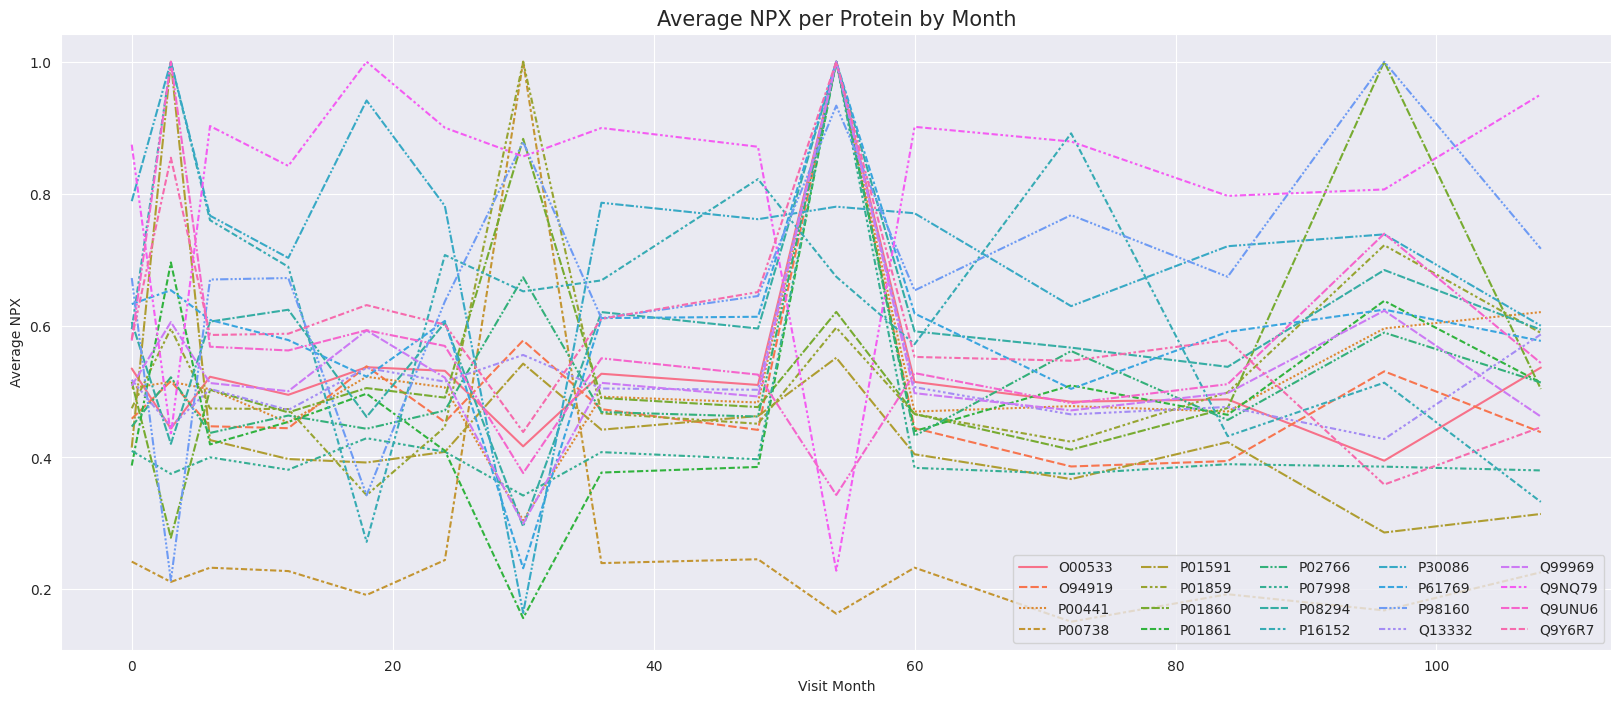

In [31]:
import math

proteins_of_interest_by_month = {
    "UniProt": [],
    "Visit Month": [],
    "Average NPX": [],
}
for protein in proteins_with_large_std:
    for month_index, month in enumerate(unique_months):
        proteins_of_interest_by_month["UniProt"].append(protein)
        proteins_of_interest_by_month["Visit Month"].append(month)
        value = protein_dict[protein]["avg_NPX"][month_index]
        value /= protein_dict[protein]["max_NPX"]
        proteins_of_interest_by_month["Average NPX"].append(value)
        
df = pd.DataFrame(proteins_of_interest_by_month)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))

sns.set_style('darkgrid')

_ = sns.lineplot(data=df, x="Visit Month", y="Average NPX", hue="UniProt", style="UniProt", ax=ax)
_ = ax.set_title("Average NPX per Protein by Month", fontsize=15)
_ = ax.set_xlabel("Visit Month")
_ = ax.set_ylabel("Average NPX")
_ = plt.legend(ncol=5)

There are some interesting observations to be made here. First, at months 30, 54, and 96 we see upward and downward spikes of the average levels of all the proteins of interest. Whether this is correlated with clinical data such as medication state or UPDRS scores is something we will look into in more detail below when we look directly at protein features. For now, we're just curious if there are correlations with proteins and visit month, which clearly there appear to be. 

The second observation is that several proteins have both upward and downward movement. This means that the proteins may be positively or negatively correlated with UPDRS scores. 

The third and final observation is that we are only looking at protein expression frequencies that have a very large variance from month to month (standard deviation > 25% of the mean). There may be other, subtler shifts in expression frequency that a machine learning algorithm can learn from.

# 2.2 - Protein UniProt and NPX

While we've started to examine the impact of `visit_month` on various protein levels, we can also look at the protein expression levels themselves to see if there are correlations between them and UPDRS scores. There are a large number of proteins (227), so we'll first take a look overall before highlighting interesting correlations.

In [32]:
proteins = []
protein_dict = {}
for index, row in train_protiens.iterrows():
    protein = row["UniProt"]
    if protein not in protein_dict:
        protein_dict[protein] = {}
        proteins.append(protein)
    protein_dict[protein][row["visit_id"]] = row["NPX"]
    
peptides = []
peptide_dict = {}
for index, row in train_peptides.iterrows():
    peptide = row["Peptide"]
    if peptide not in peptide_dict:
        peptide_dict[peptide] = {}
        peptides.append(peptide)
    peptide_dict[peptide][row["visit_id"]] = row["PeptideAbundance"]
    
train_copy = train_clinical_data.copy()
for protein in proteins:
    train_copy[protein] = train_copy["visit_id"].apply(lambda visit_id: 0 if visit_id not in protein_dict[protein] else protein_dict[protein][visit_id])
    
for peptide in peptides:
    train_copy[peptide] = train_copy["visit_id"].apply(lambda visit_id: 0 if visit_id not in peptide_dict[peptide] else peptide_dict[peptide][visit_id])

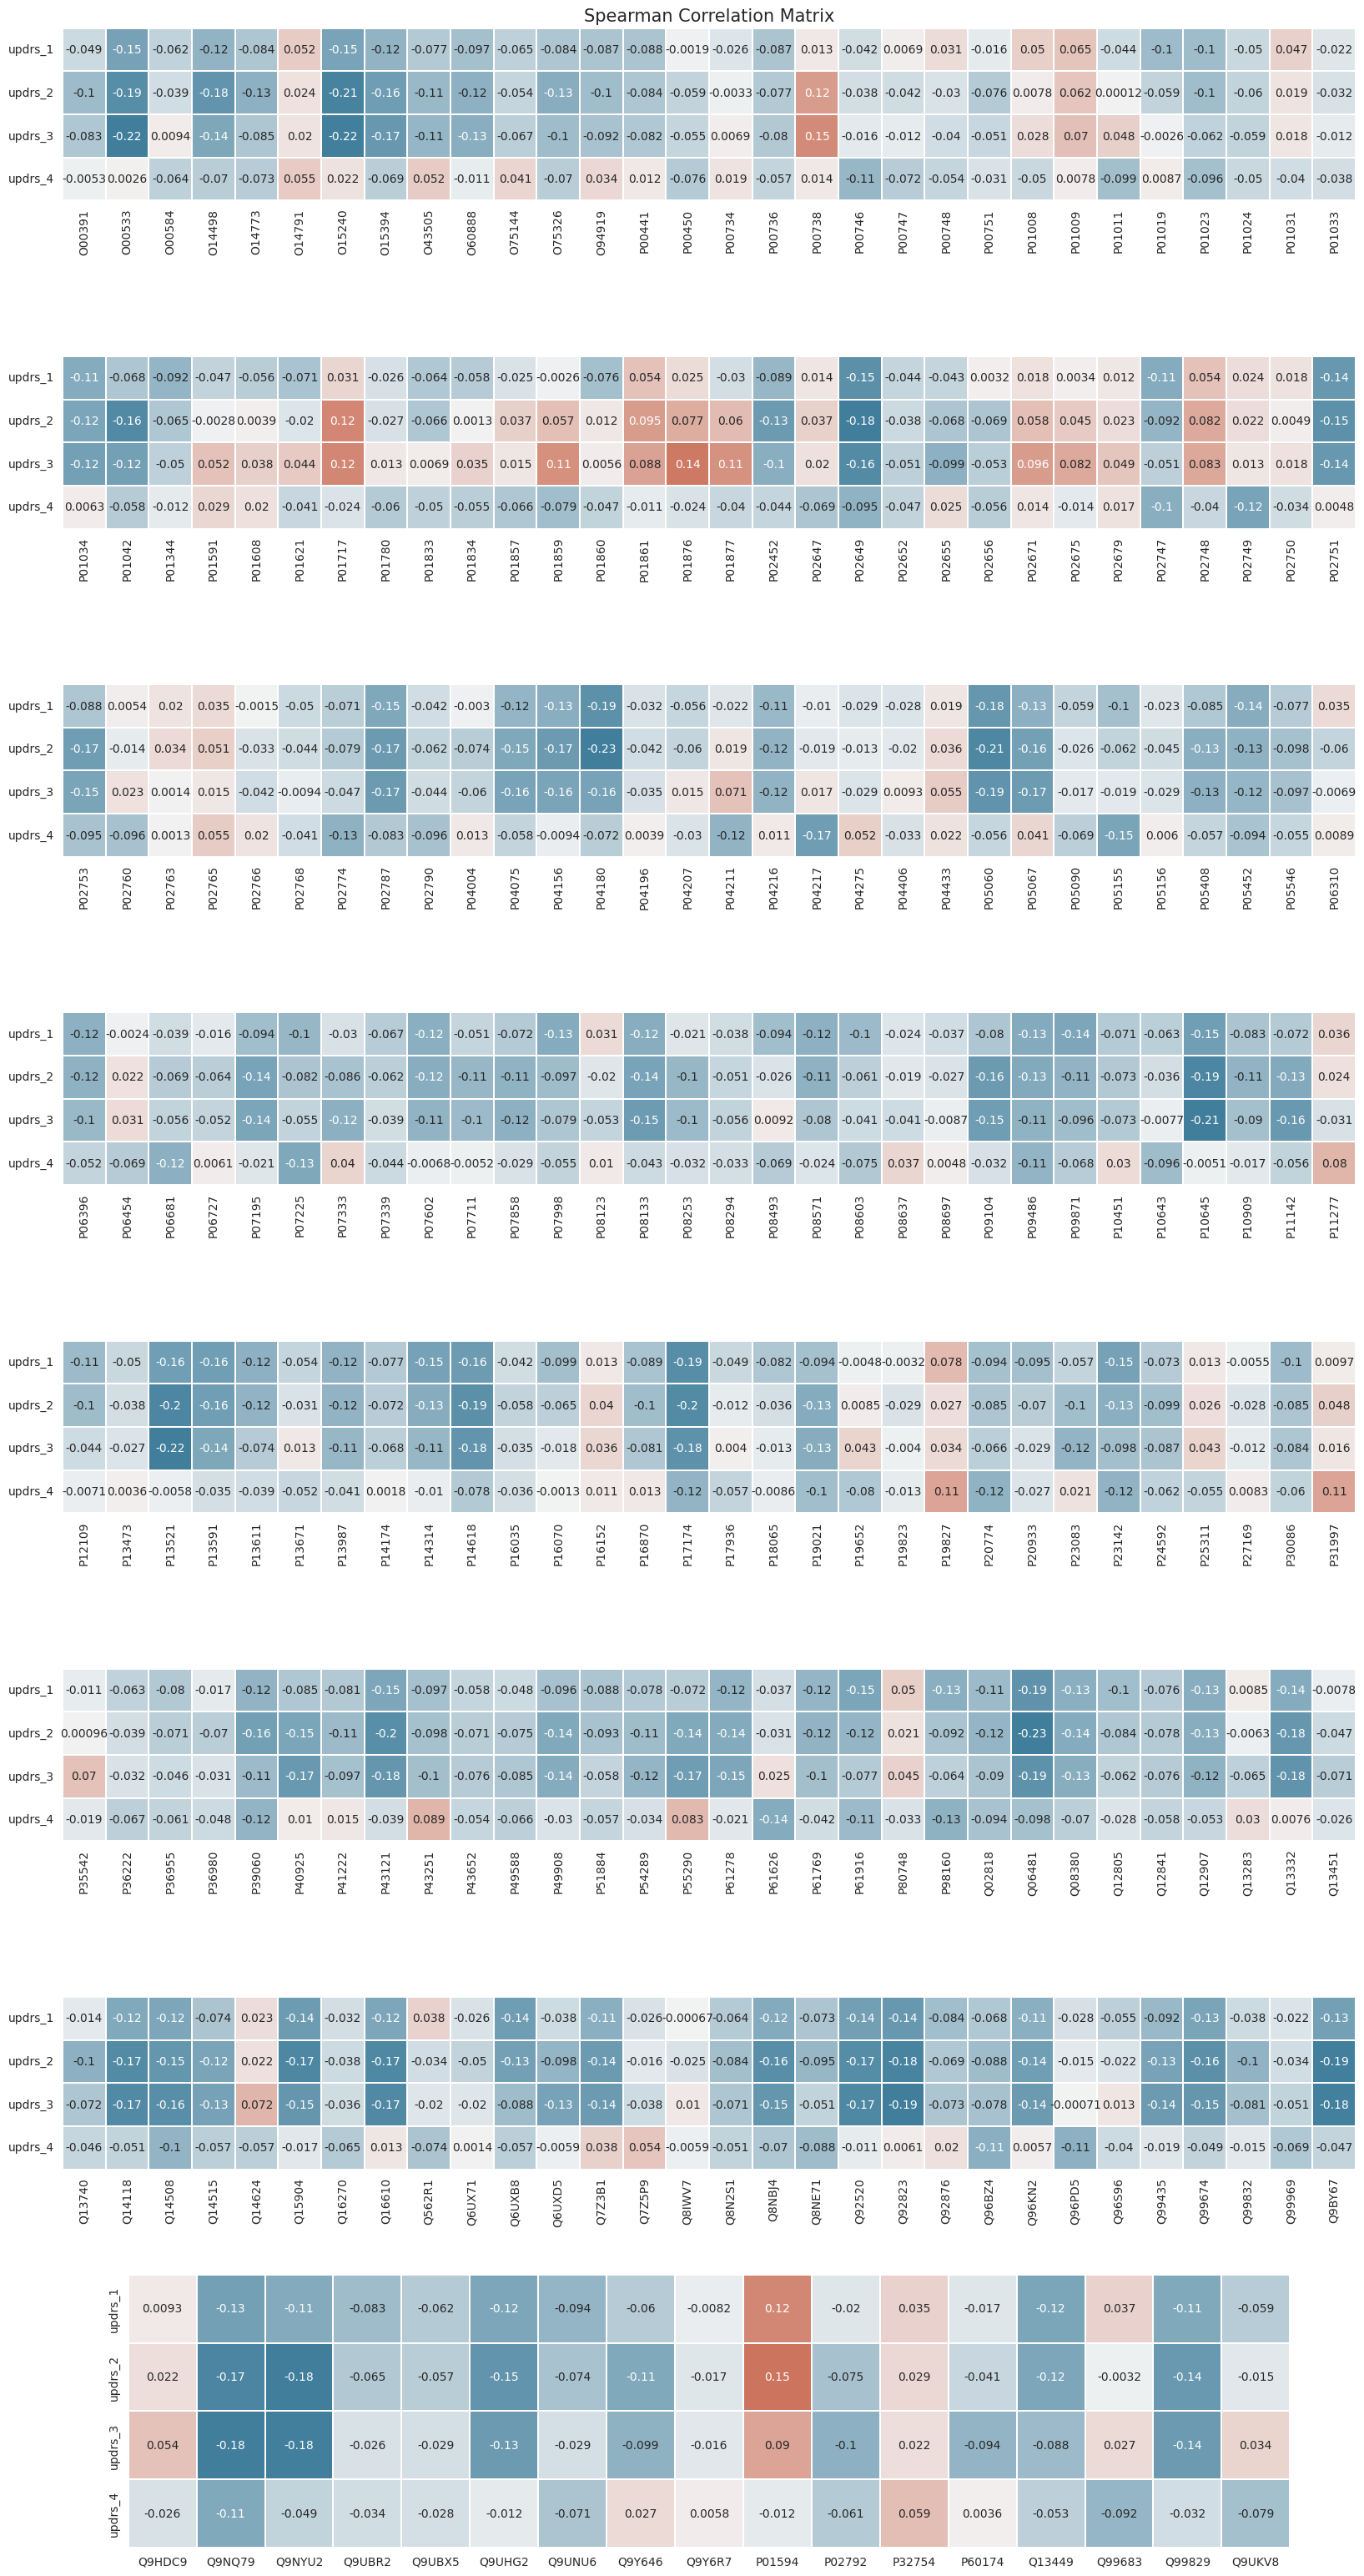

In [33]:
features = []
features.extend(proteins)

# Set missing values to null so our correlation matrix won't include 0 values in the correlation calculation
train_copy[features] = train_copy[features].replace(0.0, np.nan)

features.extend(["updrs_1", "updrs_2", "updrs_3", "updrs_4"])

correlation_matrix = train_copy[features].corr(method="spearman")

from matplotlib.colors import SymLogNorm

fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(20, 40))

axs = axs.flatten()

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,0:30],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[0], annot=True,
)
_ = axs[0].set_title("Spearman Correlation Matrix", fontsize=15)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,30:60],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[1], annot=True,
)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,60:90],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[2], annot=True,
)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,90:120],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[3], annot=True,
)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,120:150],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[4], annot=True,
)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,150:180],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[5], annot=True,
)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,180:210],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[6], annot=True,
)

_ = sns.heatmap(
    correlation_matrix.iloc[-4:,210:227],
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=axs[7], annot=True,
)

There are a lot of proteins to examine with the correlation matrix. Let's start by defining what we would consider to be a somewhat significant correlation (positive or negative). Values that are 0.1 or below are likely to have little correlation to the UPDRS target scores, and are likely just noise. A quick scan reveals that there are several candidates that may not be useful in our regression:

* `O00533`
* `O14498`
* `O15240`
* `O15394`
* `O43505`
* `O60888`
* `P00738`
* `P01034`
* `P01042`
* `P01717`
* `P02452`
* `P02649`
* `P02751`
* `P02753`
* `P02787`
* `P04075`
* `P04156`
* `P04180`
* `P04216`
* `P05060`
* `P05067`
* `P05155`
* `P05408`
* `P05452`
* `P06396`
* `P07195`
* `P07225`
* `P07602`
* `P07711`
* `P07858`
* `P08133`
* `P08253`
* `P08571`
* `P09104`
* `P09486`
* `P09871`
* `P10645`
* `P11142`
* `P13521`
* `P13591`
* `P13611`
* `P13987`
* `P14313`
* `P14618`
* `P17174`
* `P19021`
* `P23083`
* `P23142`
* `P39060`
* `P40925`
* `P43121`
* `P49908`
* `P54289`
* `P55290`
* `P61278`
* `P61769`
* `P61916`
* `P98160`
* `Q02818`
* `Q06481`
* `Q08380`
* `Q12907`
* `Q13332`
* `Q14118`
* `Q14508`
* `Q14515`
* `Q15904`
* `Q16610`
* `Q6UXB8`
* `Q7Z3B1`
* `Q8NBJ4`
* `Q92520`
* `Q92823`
* `Q96KN2`
* `Q99435`
* `Q99674`
* `Q9BY67`
* `Q9NQ79`
* `Q9NYU2`
* `Q9UHG2`
* `P01594`
* `Q13449`
* `Q99829`

There are some proteins that are weak correlates _only_ to `updrs_4`. These are:

* `P00746`
* `P02749`
* `P02774`
* `P04211`
* `P04217`
* `P05155`
* `P06681`
* `P19827`
* `P20774`
* `P31997`
* `P61626`
* `Q96BZ4`
* `Q96PD5`

The challenge is going to be how we use this knowledge. Our correlation analysis only worked because we were able to ignore values that were missing. For machine learning regression to work, we'll need to satisfy one of the following conditions to use the data:

* Have complete records for every protein type for every visit.
* Figure out a way of imputing missing values.
* Use a machine learning algorithm that implicitly handles missing data.

Let's take a look at how our proteins appear across visits. Specifically, we know that there are are 2,615 unique visits. The question is how much of each protein we see given the total number of visits we have. If we only see a protein three or four times, even if it is correlated with an UPDRS score, it's likely not going to help out too much.

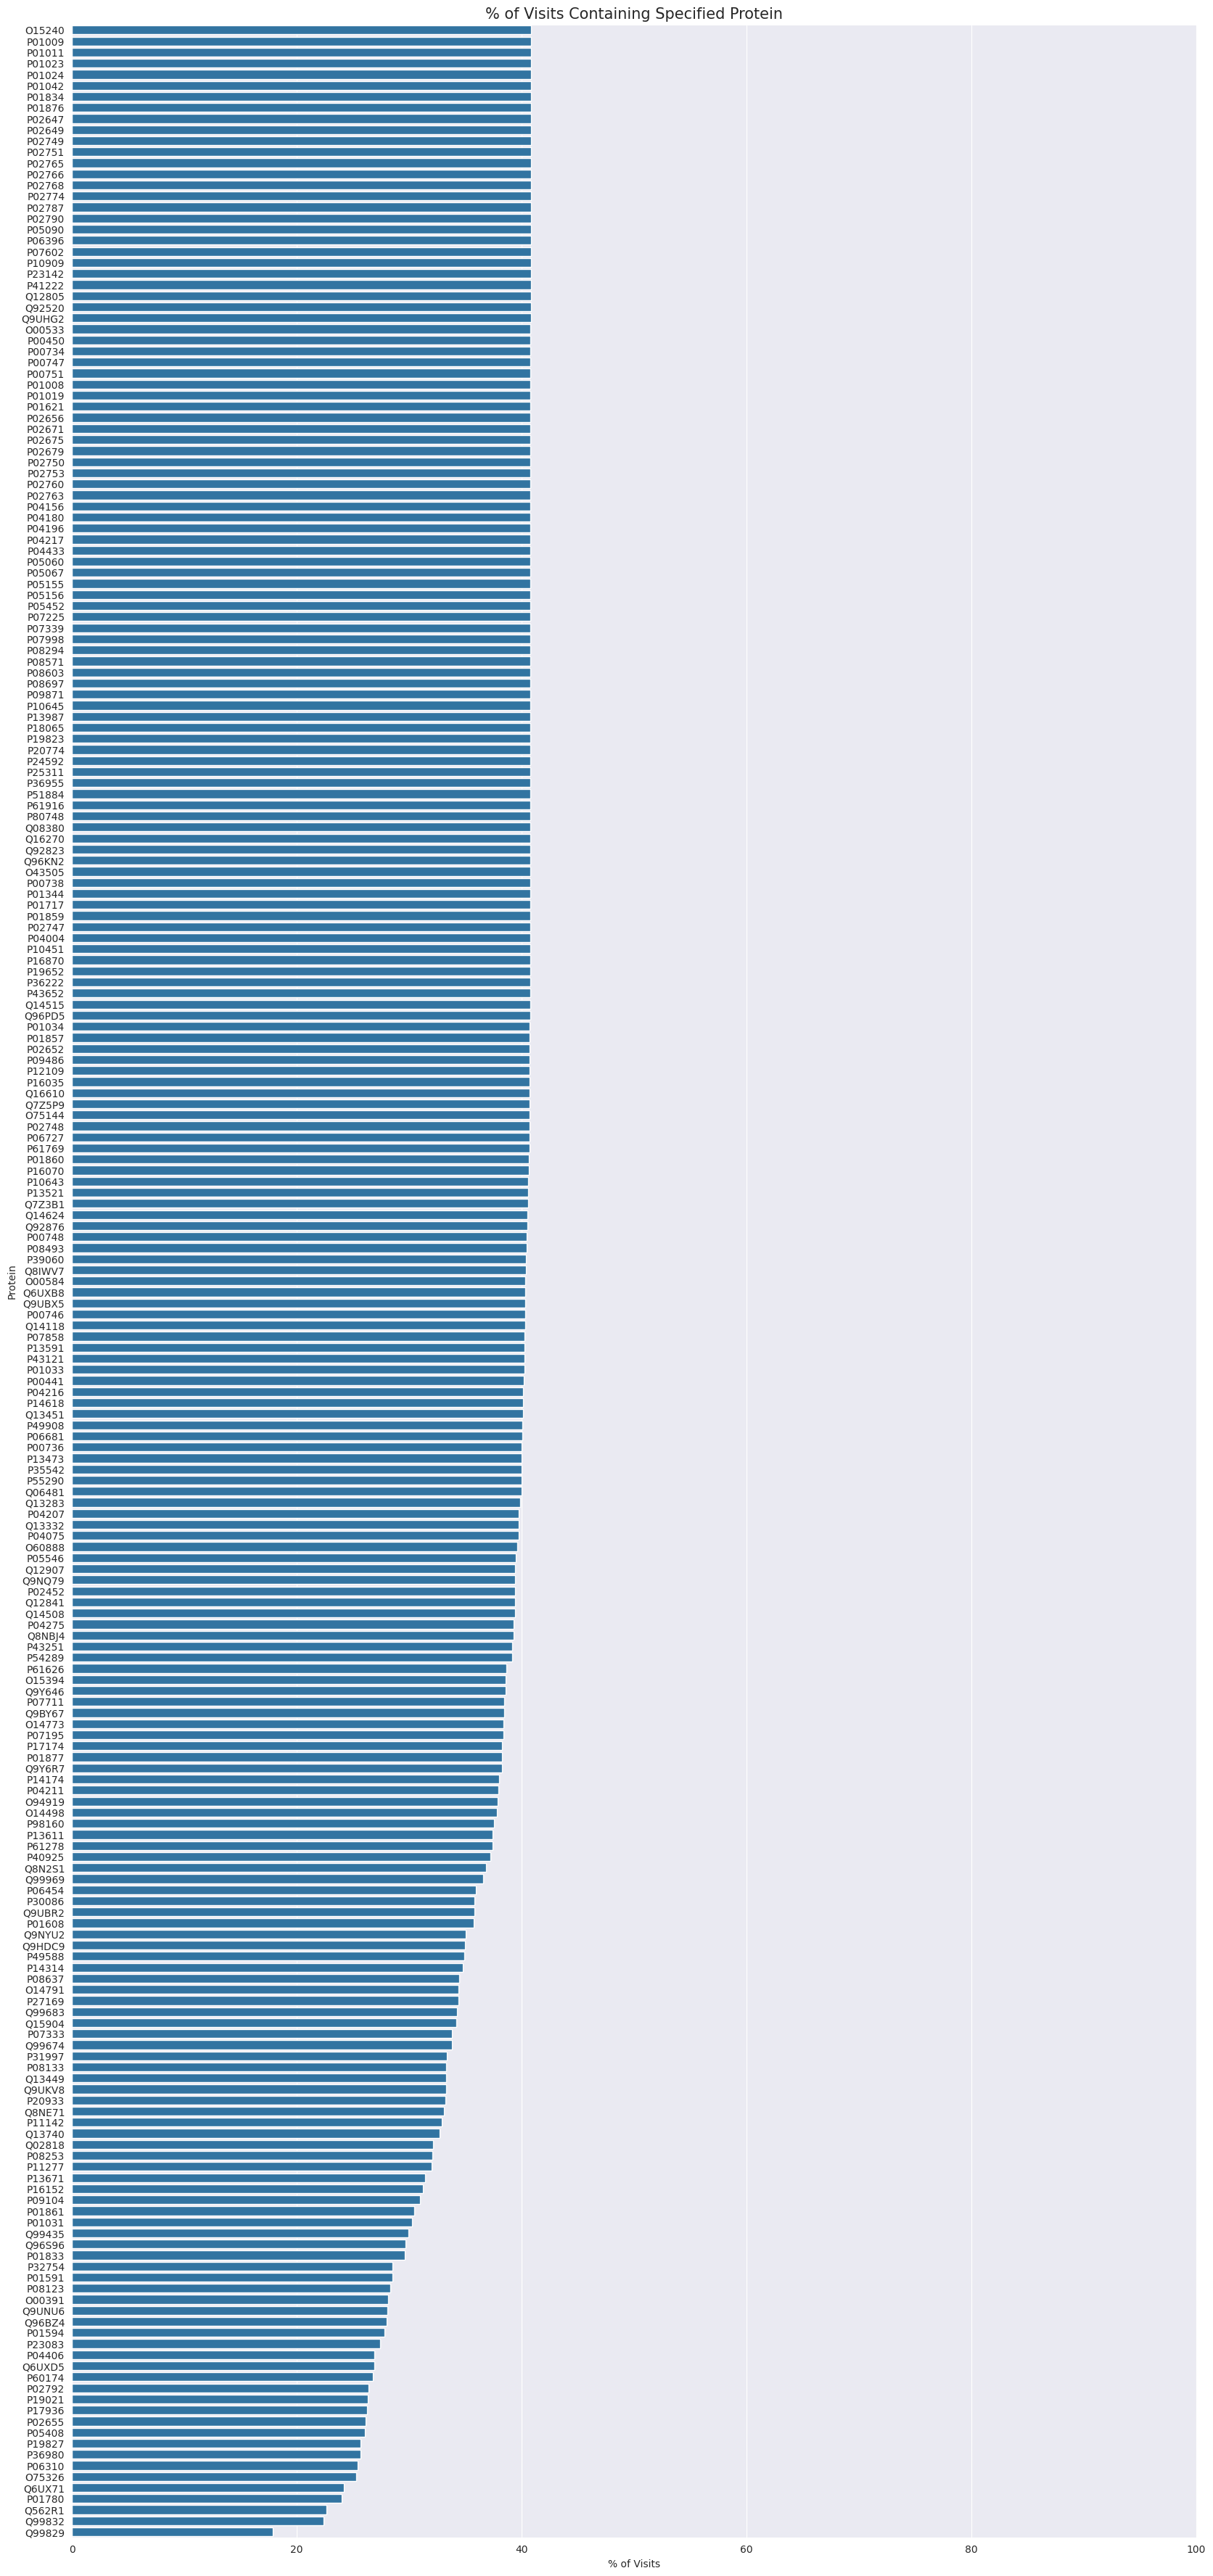

In [34]:
protein_counts = {}

for protein in proteins:
    protein_counts[protein] = float(len(train_copy[(train_copy[protein] > 0.0)][protein])) / len(train_copy[protein]) * 100

protein_counts = dict(sorted(protein_counts.items(), key=lambda x:x[1], reverse=True))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 45))

_ = sns.barplot(y=list(protein_counts.keys()), x=list(protein_counts.values()), ax=ax)
_ = ax.set_title("% of Visits Containing Specified Protein", fontsize=15)
_ = ax.set_ylabel("Protein")
_ = ax.set_xlabel("% of Visits")
_ = ax.set_xlim([0, 100])

It appears that for all of the protein data, proteins measurement data exists for at most 40% of the visits we have on record. This is going to be somewhat problematic to track trends. The instances where we don't have measurements for a specific protein are going to overwhelm examples where we do have protein measurements, creating a confounding effect. Even more problematic is the visit months where those measurements come from. 

In [35]:
protein_month_counts = {}

for protein in proteins:
    protein_month_counts[protein] = {month: 0 for month in range(109)}
    for x in range(109):
        protein_month_counts[protein][x] = len(train_copy[(train_copy[protein] > 0.0) & (train_copy["visit_month"] == x)][protein])

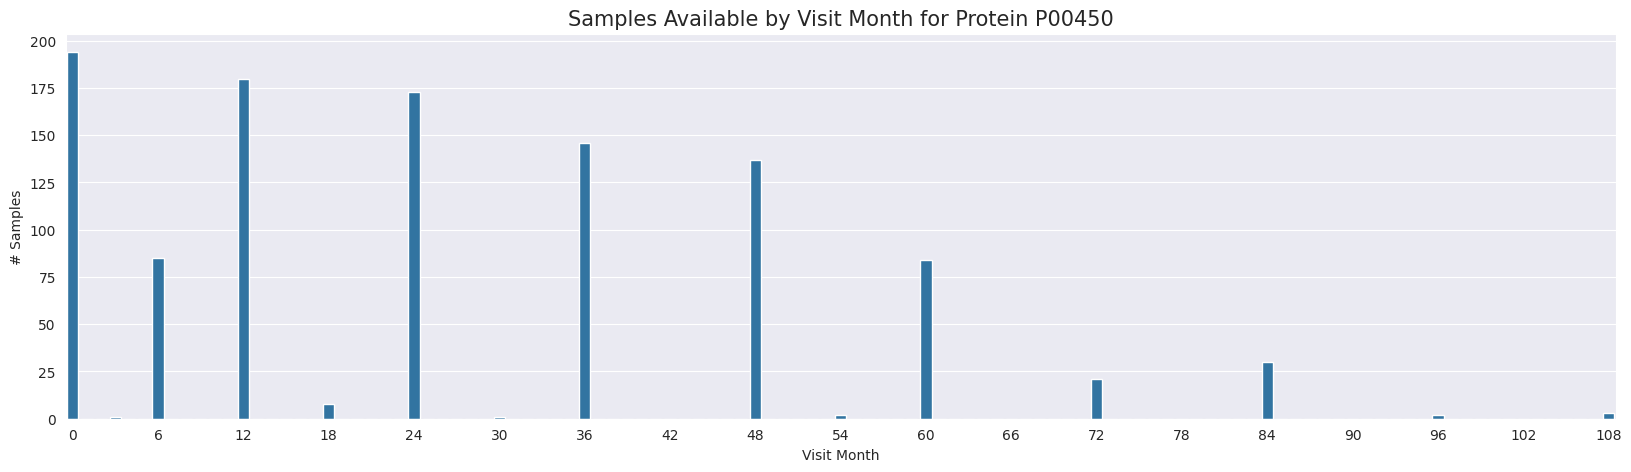

In [36]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

_ = sns.barplot(x=list(protein_month_counts["P00450"].keys()), y=list(protein_month_counts["P00450"].values()), ax=ax)
_ = ax.set_title("Samples Available by Visit Month for Protein P00450", fontsize=15)
_ = ax.set_ylabel("# Samples")
_ = ax.set_xlabel("Visit Month")
_ = ax.xaxis.set_major_locator(MultipleLocator(6))
_ = ax.xaxis.set_major_formatter('{x:.0f}')
_ = ax.xaxis.set_minor_locator(MultipleLocator(3))

We should also look at it in terms of patients at each month. What percentage of patients are lacking protein data? Do we have representation of proteins at every month for at least some of our patients?

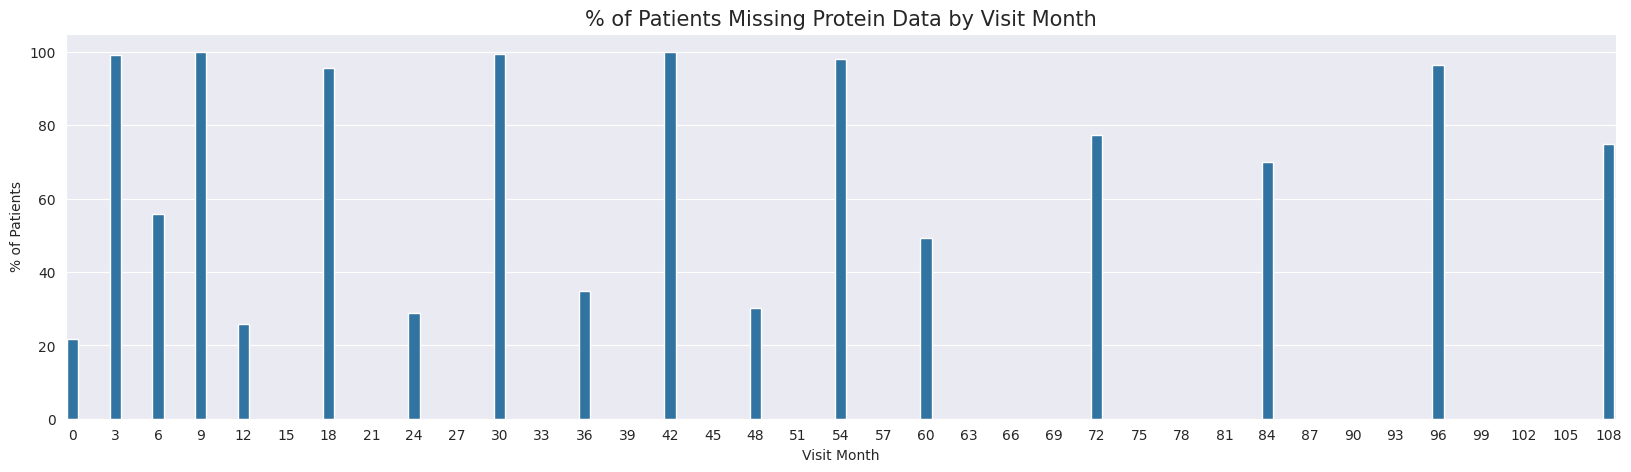

In [37]:
train_copy = train_copy.fillna(0)
train_copy["missing_all"] = train_copy[proteins].apply(lambda x: 1 if sum([y for y in x]) == 0 else 0, axis=1)

missing_month_counts = [train_copy[(train_copy["visit_month"] == x)]["missing_all"].sum() / float(train_copy[(train_copy["visit_month"] == x)]["patient_id"].count()) * 100 for x in range(109)]
missing_month_labels = [x for x in range(109)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

_ = sns.barplot(x=missing_month_labels, y=missing_month_counts, ax=ax)
_ = ax.set_title("% of Patients Missing Protein Data by Visit Month", fontsize=15)
_ = ax.set_ylabel("% of Patients")
_ = ax.set_xlabel("Visit Month")
_ = ax.xaxis.set_major_locator(MultipleLocator(3))
_ = ax.xaxis.set_major_formatter('{x:.0f}')
_ = ax.xaxis.set_minor_locator(MultipleLocator(3))

As we can see, at months 3, 9, 18, 30, 42, 54, and 96, we are lacking protein data for nearly all of the patients in the study.

# 3 - Research Papers

There is a body of real-world research that may provide some targeted insights into the data that we have at hand.

# 3.1 - Cerebrospinal Fluid Peptides as Potential Parkinson Disease Biomarkers (2015)

The research by Shi et al (2015) looks specifically at CSF proteins and peptides that are potential indicators of Parkinson's Disease. Of those identified, the following are available in the training data that we have available:

* Proteins:
    * `P00450` - Ceruloplasmin (CP)
    * `P07333` - Macrophage colony-stimulating factor 1 receptor (CSF1R)
    * `P10451` - Osteopontin (SPP1)
    * `P01033` - Metalloproteinase inhibitor 1 (TIMP1)
    * `P01008` - Antithrombin-III (SERPINC1)
    * `P02647` - Apolipoprotein A-I (APOA1)
    * `P01024` - Complement C3 (C3)
    * `Q92876` - Kallikrein-6 (KLK6)
* Peptides:
    * `GAYPLSIEPIGVR` - associated with protein Ceruloplasmin (CP)
    * `EPGLC(UniMod_4)TWQSLR` - associated with protein Metalloproteinase inhibitor 1 (TIMP1)
    * `WQEEMELYR` - associated with protein Apolipoprotein A-I (APOA1)
    * `QPSSAFAAFVK` - associated with protein Complement C3 (C3)
    * `GLVSWGNIPC(UniMod_4)GSK` - associated with protein Kallikrein-6 (KLK6)
    
We should check to see how these protein levels impact UPDRS scores. Let's start by checking correlation of these peptide and protein levels against various UPDRS scores.

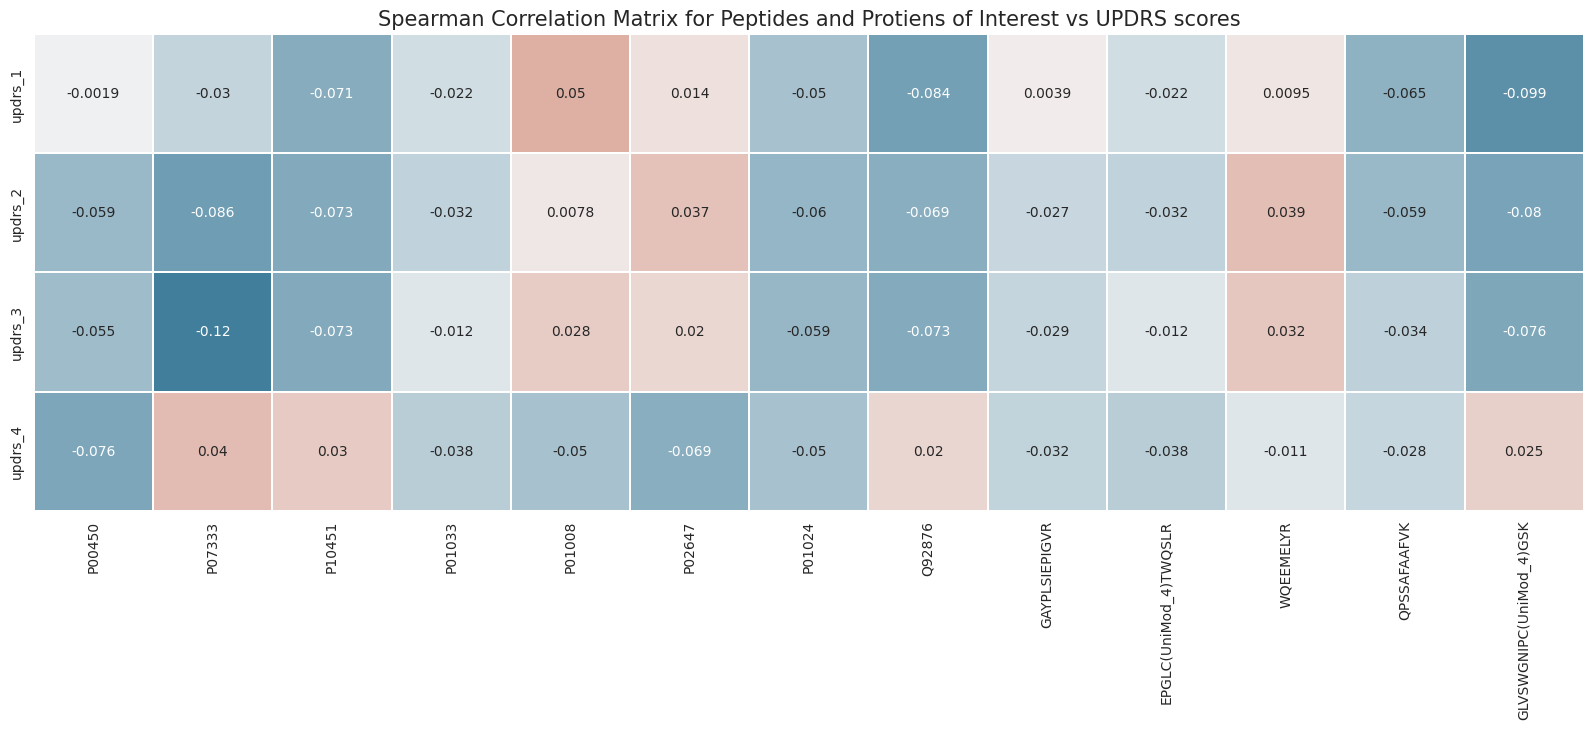

In [38]:
proteins = ["P00450", "P07333", "P10451", "P01033", "P01008", "P02647", "P01024", "Q92876"]
peptides = ["GAYPLSIEPIGVR", "EPGLC(UniMod_4)TWQSLR", "WQEEMELYR", "QPSSAFAAFVK", "GLVSWGNIPC(UniMod_4)GSK"]

protein_dict = {}
for index, row in train_protiens.iterrows():
    protein = row["UniProt"]
    if protein not in protein_dict:
        protein_dict[protein] = {}
    protein_dict[protein][row["visit_id"]] = row["NPX"]
    
peptide_dict = {}
for index, row in train_peptides.iterrows():
    peptide = row["Peptide"]
    if peptide not in peptide_dict:
        peptide_dict[peptide] = {}
    peptide_dict[peptide][row["visit_id"]] = row["PeptideAbundance"]
    
train_copy = train_clinical_data.copy()
for protein in proteins:
    train_copy[protein] = train_copy["visit_id"].apply(lambda visit_id: 0 if visit_id not in protein_dict[protein] else protein_dict[protein][visit_id])
    
for peptide in peptides:
    train_copy[peptide] = train_copy["visit_id"].apply(lambda visit_id: 0 if visit_id not in peptide_dict[peptide] else peptide_dict[peptide][visit_id])
    
features = []
features.extend(proteins)
features.extend(peptides)

# Set missing values to null so our correlation matrix won't include 0 values in the correlation calculation
train_copy[features] = train_copy[features].replace(0.0, np.nan)

features.extend(["updrs_1", "updrs_2", "updrs_3", "updrs_4"])

correlation_matrix = train_copy[features].corr(method="spearman")

from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix.iloc[13:17,0:13], 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix for Peptides and Protiens of Interest vs UPDRS scores", fontsize=15)

Some interesting observations here. None of the peptides or proteins have any significant positive or negative correlation to UPDRS scores except for:

* Protein `P07333` has a weak negative correlation to `updrs_3`
* Peptide `GLVSWGNIPC(UniMod_4)GSK` has a weak negative correlation to `updrs_1`. 

These observations fall in line with the findings from the paper. In brief, the authors noted that no single protein or peptide in isolation had a clear correlation to UPDRS scores - it was only in combination with other peptides and proteins that a stronger signal was present. The paper outlines a 2-peptide model that had strong correlations with overall disease severity. Unfortunately, the training dataset does not have the correct combination of proteins and peptides as described in the paper. Nonetheless, these two findings above may be enough to provide minimal lift.

# 4 - Models

Given what we know of the data, we can now create a series of models and see if our knowledge of features and their properties can be used to our advantage.

# 4.1 - Baseline CatBoost Model

The first model we'll construct is a simple one - we'll use absolutely no protein or peptide data. In essence, we'll end up just using prior information about visit month to make predictions for the future. Function for computing SMAPE score was graciously borrowed from [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) post on [How to calculate the SMAPE score](https://www.kaggle.com/competitions/tabular-playground-series-jan-2022/discussion/298201).

In [41]:
train_dict = {}

for index, row in train_clinical_data.iterrows():
    patient_id = row["patient_id"]
    visit_month = row["visit_month"]
    if patient_id not in train_dict:
        train_dict[patient_id] = {}
    train_dict[patient_id][visit_month] = {
           "updrs_1": row["updrs_1"],
           "updrs_2": row["updrs_2"],
           "updrs_3": row["updrs_3"],
           "updrs_4": row["updrs_4"],
    }
    
train = train_clinical_data.copy()
train["month_offset"] = 0

for index, row in train_clinical_data.iterrows():
    visit_id = row["visit_id"]
    patient_id = row["patient_id"]
    visit_month = row["visit_month"]
    month_offsets = [6, 12, 24]
    for month_offset in month_offsets:
        new_visit_month = visit_month + month_offset
        if new_visit_month in train_dict[patient_id]:
            new_row = {
                "visit_id": visit_id,
                "visit_month": visit_month,
                "month_offset": month_offset,
                "patient_id": patient_id,
                "updrs_1": train_dict[patient_id][new_visit_month]["updrs_1"],
                "updrs_2": train_dict[patient_id][new_visit_month]["updrs_2"],
                "updrs_3": train_dict[patient_id][new_visit_month]["updrs_3"],
                "updrs_4": train_dict[patient_id][new_visit_month]["updrs_4"],
                "upd23b_clinical_state_on_medication": row["upd23b_clinical_state_on_medication"],
            }
            # train = train.append(new_row, ignore_index=True)
            train = pd.concat([train, pd.DataFrame([new_row])], ignore_index=True)

In [42]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

def smape(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

features = [
    'visit_month', 'month_offset',
]

train_copy = train.copy()
train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]] = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].fillna(0)

n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0], 4))
smape_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[train_index], train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = CatBoostRegressor(
        eval_metric="MultiRMSE",
        loss_function="MultiRMSE",
        random_state=2023,
        num_boost_round=5000,
        od_type="Iter",
        od_wait=200,
        use_best_model=True,
        verbose=0,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        verbose=0,
        early_stopping_rounds=200,
        use_best_model=True,
    )
    oof_preds = model.predict(x_valid_features[features])
    train_oof_preds[test_index] = np.rint(oof_preds)

    reshaped_truth = y_valid.to_numpy().reshape(-1, 1)
    new_preds = np.rint(oof_preds)
    reshaped_preds = new_preds.reshape(-1, 1)

    local_smape = smape(reshaped_truth.flatten(), reshaped_preds.flatten())
    smape_scores.append(local_smape)
    print(": SMAPE = {}".format(local_smape))
    
smape_baseline = np.mean(smape_scores)
print("--> Overall results for out of fold predictions")
print(": SMAPE = {}".format(smape_baseline))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "SMAPE": smape_scores})
_ = sns.lineplot(x="Fold", y="SMAPE", data=data, ax=ax)
_ = ax.set_title("SMAPE per Fold", fontsize=15)
_ = ax.set_ylabel("SMAPE")
_ = ax.set_xlabel("Fold #")

ModuleNotFoundError: No module named 'catboost'

As we can see, we get a SMAPE score of 95.7, which isn't great. There are however improvements we can make to this score.

# 4.2 - Constant UPDRS 4

Overall, our model currently cannot learn enough information about UPDRS 4 due to missing and null values. A simple way to handle this is to zero it out. This isn't very good from a clinical standpoint, but it will likely generate lift for us, since we won't get penalized for the many times we're likely to predict a value where there should be none. For example, see discussion [here](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/393104).

In [ ]:
features = [
    'visit_month', 'month_offset',
]

train_copy = train.copy()
train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]] = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].fillna(0)

n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0], 4))
smape_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[train_index], train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = CatBoostRegressor(
        eval_metric="MultiRMSE",
        loss_function="MultiRMSE",
        random_state=2023,
        num_boost_round=5000,
        od_type="Iter",
        od_wait=200,
        use_best_model=True,
        verbose=0,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        verbose=0,
        early_stopping_rounds=200,
        use_best_model=True,
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_preds[:, 3] = 0
    train_oof_preds[test_index] = np.rint(oof_preds)

    reshaped_truth = y_valid.to_numpy().reshape(-1, 1)
    new_preds = np.rint(oof_preds)
    reshaped_preds = new_preds.reshape(-1, 1)

    local_smape = smape(reshaped_truth.flatten(), reshaped_preds.flatten())
    smape_scores.append(local_smape)
    print(": SMAPE = {}".format(local_smape))
    
smape_updrs40 = np.mean(smape_scores)
print("--> Overall results for out of fold predictions")
print(": SMAPE = {}".format(smape_updrs40))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "SMAPE": smape_scores})
_ = sns.lineplot(x="Fold", y="SMAPE", data=data, ax=ax)
_ = ax.set_title("SMAPE per Fold", fontsize=15)
_ = ax.set_ylabel("SMAPE")
_ = ax.set_xlabel("Fold #")

As we can see, simply setting the UPDRS 4 value to 0 improves our SMAPE score. There is obviously room here to make improvements, especially if we could leverage information to make better UPDRS 4 predictions. For models moving forward, we'll continue to use the zeroed out UPDRS score.

# 4.3 - Supplemental Data

If we are going to continue to ignore protein and peptide data, then we can add in the additional clinical data to the mix. This is likely to generate lift for us, since we give the regressor more information to work with.

In [43]:
supplemental_dict = {}

for index, row in supplemental_clinical_data.iterrows():
    patient_id = row["patient_id"]
    visit_month = row["visit_month"]
    if patient_id not in supplemental_dict:
        supplemental_dict[patient_id] = {}
    supplemental_dict[patient_id][visit_month] = {
           "updrs_1": row["updrs_1"],
           "updrs_2": row["updrs_2"],
           "updrs_3": row["updrs_3"],
           "updrs_4": row["updrs_4"],
    }
    
additional = supplemental_clinical_data.copy()
additional["month_offset"] = 0

for index, row in supplemental_clinical_data.iterrows():
    visit_id = row["visit_id"]
    patient_id = row["patient_id"]
    visit_month = row["visit_month"]
    month_offsets = [6, 12, 24]
    for month_offset in month_offsets:
        new_visit_month = visit_month + month_offset
        if new_visit_month in supplemental_dict[patient_id]:
            new_row = {
                "visit_id": visit_id,
                "visit_month": visit_month,
                "month_offset": month_offset,
                "patient_id": patient_id,
                "updrs_1": supplemental_dict[patient_id][new_visit_month]["updrs_1"],
                "updrs_2": supplemental_dict[patient_id][new_visit_month]["updrs_2"],
                "updrs_3": supplemental_dict[patient_id][new_visit_month]["updrs_3"],
                "updrs_4": supplemental_dict[patient_id][new_visit_month]["updrs_4"],
                "upd23b_clinical_state_on_medication": row["upd23b_clinical_state_on_medication"],
            }
            additional = additional.append(new_row, ignore_index=True)

additional[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]] = additional[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].fillna(0)

features = [
    'visit_month', 'month_offset',
]

train_copy = train.copy()
train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]] = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].fillna(0)

n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0], 4))
smape_scores = []

chunk_size = int(len(additional) / n_folds)
additional_chunks = [additional[i:i+chunk_size] for i in range(0, len(additional), chunk_size)]

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[train_index], train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_train_features = pd.concat([x_train_features, additional_chunks[fold]]).reset_index(drop=True)
    y_train = y_train.append(additional_chunks[fold][["updrs_1", "updrs_2", "updrs_3", "updrs_4"]])
    
    x_valid_features = pd.DataFrame(x_valid[features])

    model = CatBoostRegressor(
        eval_metric="MultiRMSE",
        loss_function="MultiRMSE",
        random_state=2023,
        num_boost_round=5000,
        od_type="Iter",
        od_wait=200,
        use_best_model=True,
        verbose=0,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        verbose=0,
        early_stopping_rounds=200,
        use_best_model=True,
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_preds[:, 3] = 0
    train_oof_preds[test_index] = np.rint(oof_preds)

    reshaped_truth = y_valid.to_numpy().reshape(-1, 1)
    new_preds = np.rint(oof_preds)
    reshaped_preds = new_preds.reshape(-1, 1)

    local_smape = smape(reshaped_truth.flatten(), reshaped_preds.flatten())
    smape_scores.append(local_smape)
    print(": SMAPE = {}".format(local_smape))
    
smape_additional = np.mean(smape_scores)
print("--> Overall results for out of fold predictions")
print(": SMAPE = {}".format(smape_additional))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "SMAPE": smape_scores})
_ = sns.lineplot(x="Fold", y="SMAPE", data=data, ax=ax)
_ = ax.set_title("SMAPE per Fold", fontsize=15)
_ = ax.set_ylabel("SMAPE")
_ = ax.set_xlabel("Fold #")

AttributeError: 'DataFrame' object has no attribute 'append'

We see a little improvement over using the clinical data alone. This is likely going to help us in instances where the hidden test data contains no protein information.

# 4.4 - Medication State

While the medication state of a patient isn't available on our test data, there may still be some interest in it, as we saw that the medication state did have a direct impact on UPDRS scores over time. Let's take a look and see if it could potentially provide lift if we had it.

In [44]:
features = [
    'visit_month', 'month_offset', 'med_state',
]

train_copy = train.copy()
train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]] = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].fillna(0)

n_folds = 5
skf = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train.shape[0], 4))
smape_scores = []

train_copy["med_state"] = train_copy["upd23b_clinical_state_on_medication"]
train_copy["med_state"] = train_copy["med_state"].apply(lambda x: 0 if x == "Off" else 1 if x == "On" else 2)

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[train_index], train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[features])
    x_valid_features = pd.DataFrame(x_valid[features])

    model = CatBoostRegressor(
        eval_metric="MultiRMSE",
        loss_function="MultiRMSE",
        random_state=2023,
        num_boost_round=5000,
        od_type="Iter",
        od_wait=200,
        use_best_model=True,
        verbose=0,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        verbose=0,
        early_stopping_rounds=200,
        use_best_model=True,
    )
    oof_preds = model.predict(x_valid_features[features])
    oof_preds[:, 3] = 0
    train_oof_preds[test_index] = np.rint(oof_preds)

    reshaped_truth = y_valid.to_numpy().reshape(-1, 1)
    new_preds = np.rint(oof_preds)
    reshaped_preds = new_preds.reshape(-1, 1)

    local_smape = smape(reshaped_truth.flatten(), reshaped_preds.flatten())
    smape_scores.append(local_smape)
    print(": SMAPE = {}".format(local_smape))
    
smape_med = np.mean(smape_scores)
print("--> Overall results for out of fold predictions")
print(": SMAPE = {}".format(smape_med))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "SMAPE": smape_scores})
_ = sns.lineplot(x="Fold", y="SMAPE", data=data, ax=ax)
_ = ax.set_title("SMAPE per Fold", fontsize=15)
_ = ax.set_ylabel("SMAPE")
_ = ax.set_xlabel("Fold #")

-------> Fold 1 <--------


NameError: name 'CatBoostRegressor' is not defined

We can see that there is lift to our model if we take into account medication state. This suggests that maybe a classifier capable of soft-labeling medication state may be applicable, assuming there is signal in the protein data to provide context for the classifier to work with.

# 4.5 - Protein Data

Up until now, we haven't looked at all at protein or peptide information. Let's see what happens when we add in data/raw numbers.

In [46]:
# from sklearn.model_selection import GroupKFold

# features = [
#     "visit_month", "month_offset", "O00391", "O00533", "O00584", "O14498", "O14773", "O14791", "O15240", 
#     "O15394", "O43505", "O60888", "O75144", "O75326", "O94919", "P00441", "P00450", "P00734", "P00736", 
#     "P00738", "P00746", "P00747", "P00748", "P00751", "P01008", "P01009", "P01011", "P01019", "P01023", 
#     "P01024", "P01031", "P01033", "P01034", "P01042", "P01344", "P01591", "P01608", "P01621", "P01717", 
#     "P01780", "P01833", "P01834", "P01857", "P01859", "P01860", "P01861", "P01876", "P01877", "P02452", 
#     "P02647", "P02649", "P02652", "P02655", "P02656", "P02671", "P02675", "P02679", "P02747", "P02748",
#     "P02749", "P02750", "P02751", "P02753", "P02760", "P02763", "P02765", "P02766", "P02768", "P02774",
#     "P02787", "P02790", "P04004", "P04075", "P04156", "P04180", "P04196", "P04207", "P04211", "P04216", 
#     "P04217", "P04275", "P04406", "P04433", "P05060", "P05067", "P05090", "P05155", "P05156", "P05408", 
#     "P05452", "P05546", "P06310", "P06396", "P06454", "P06681", "P06727", "P07195", "P07225", "P07333", 
#     "P07339", "P07602", "P07711", "P07858", "P07998", "P08123", "P08133", "P08253", "P08294", "P08493", 
#     "P08571", "P08603", "P08637", "P08697", "P09104", "P09486", "P09871", "P10451", "P10643", "P10645", 
#     "P10909", "P11142", "P11277", "P12109", "P13473", "P13521", "P13591", "P13611", "P13671", "P13987", 
#     "P14174", "P14314", "P14618", "P16035", "P16070", "P16152", "P16870", "P17174", "P17936", "P18065", 
#     "P19021", "P19652", "P19823", "P19827", "P20774", "P20933", "P23083", "P23142", "P24592", "P25311", 
#     "P27169", "P30086", "P31997", "P35542", "P36222", "P36955", "P36980", "P39060", "P40925", "P41222", 
#     "P43121", "P43251", "P43652", "P49588", "P49908", "P51884", "P54289", "P55290", "P61278", "P61626", 
#     "P61769", "P61916", "P80748", "P98160", "Q02818", "Q06481", "Q08380", "Q12805", "Q12841", "Q12907", 
#     "Q13283", "Q13332", "Q13451", "Q13740", "Q14118", "Q14508", "Q14515", "Q14624", "Q15904", "Q16270",
#     "Q16610", "Q562R1", "Q6UX71", "Q6UXB8", "Q6UXD5", "Q7Z3B1", "Q7Z5P9", "Q8IWV7", "Q8N2S1", "Q8NBJ4",
#     "Q8NE71", "Q92520", "Q92823", "Q92876", "Q96BZ4", "Q96KN2", "Q96PD5", "Q96S96", "Q99435", "Q99674", 
#     "Q99832", "Q99969", "Q9BY67", "Q9HDC9", "Q9NQ79", "Q9NYU2", "Q9UBR2", "Q9UBX5", "Q9UHG2", "Q9UNU6", 
#     "Q9Y646", "Q9Y6R7", "P01594", "P02792", "P32754", "P60174", "Q13449", "Q99683", "Q99829", "Q9UKV8"
# ]

# train_copy = train.copy()
# train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]] = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].fillna(0)

# proteins = train_protiens["UniProt"].unique()

# protein_visit_dict = {}
# for protein in proteins:
#     if protein not in protein_visit_dict:
#         protein_visit_dict[protein] = {}
#     for index, row in train_protiens[(train_protiens["UniProt"] == protein)].iterrows():
#         visit_id = row["visit_id"]
#         protein_visit_dict[protein][visit_id] = row["NPX"]
        
# for protein in proteins:
#     train_copy[protein] = train_copy["visit_id"].apply(
#            lambda visit_id: protein_visit_dict[protein][visit_id] if visit_id in protein_visit_dict[protein] else 0
#     )

# n_folds = 5
# skf = GroupKFold(n_splits=n_folds)
# train_oof_preds = np.zeros((train.shape[0], 4))
# smape_scores = []

# for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]], groups=train_copy["patient_id"])):
#     print("-------> Fold {} <--------".format(fold + 1))
#     x_train, x_valid = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
#     y_train, y_valid = train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[train_index], train_copy[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].iloc[test_index]
    
#     x_train_features = pd.DataFrame(x_train[features])
#     x_valid_features = pd.DataFrame(x_valid[features])

#     model = CatBoostRegressor(
#         eval_metric="MultiRMSE",
#         loss_function="MultiRMSE",
#         random_state=2023,
#         num_boost_round=5000,
#         od_type="Iter",
#         od_wait=200,
#         use_best_model=True,
#         verbose=0,    
#     )
#     model.fit(
#         x_train_features[features], 
#         y_train,
#         eval_set=[(x_valid_features[features], y_valid)],
#         verbose=0,
#         early_stopping_rounds=200,
#         use_best_model=True,
#     )
#     oof_preds = model.predict(x_valid_features[features])
#     oof_preds[:, 3] = 0
#     train_oof_preds[test_index] = np.rint(oof_preds)

#     reshaped_truth = y_valid.to_numpy().reshape(-1, 1)
#     new_preds = np.rint(oof_preds)
#     reshaped_preds = new_preds.reshape(-1, 1)

#     local_smape = smape(reshaped_truth.flatten(), reshaped_preds.flatten())
#     smape_scores.append(local_smape)
#     print(": SMAPE = {}".format(local_smape))
    
# smape_protein = np.mean(smape_scores)
# print("--> Overall results for out of fold predictions")
# print(": SMAPE = {}".format(smape_protein))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "SMAPE": smape_scores})
# _ = sns.lineplot(x="Fold", y="SMAPE", data=data, ax=ax)
# _ = ax.set_title("SMAPE per Fold", fontsize=15)
# _ = ax.set_ylabel("SMAPE")
# _ = ax.set_xlabel("Fold #")

# 4.x - Model Comparisons

We can compare the performance of each of our models to see which one performs the best. The red dashed line indicates baseline performance that we are looking to beat.

In [48]:
# bar, ax = plt.subplots(figsize=(20, 10))
# ax = sns.barplot(
#     x=["Baseline", "Constant UPDRS 4", "Supplemental Data", "Medication State", "Protein Data"],
#     y=[
#         smape_baseline,
#         smape_updrs40,
#         smape_additional,
#         smape_med,
#         smape_protein,
#     ]
# )
# _ = ax.axhline(y=69.51, color='r', linestyle='--')
# _ = ax.set_title("SMAPE Score (Lower is Better)", fontsize=15)
# _ = ax.set_xlabel("")
# _ = ax.set_ylabel("SMAPE")
# _ = ax.set_ylim([61, 97])
# for p in ax.patches:
#     height = p.get_height()
#     ax.text(x=p.get_x()+(p.get_width()/2), y=height, s="{:.4f}".format(height), ha="center")

# 5 - Conclusions

There are several conclusions based on our observations:

* The size of the dataset means that memory pressure will likely not be too great. 
* There are a total of 248 patients in the clinical data, and 771 patients in the supplemental data.
* In terms of missing information:
    * There are no null entries in the protein or peptide data.
    * There are null entries in the clinical data and supplemental data.
        * We cannot assume that null values indicate a 0 value for features such as UPDRS assessment parts, as values of 0 indicate a "normal" response.
        * Null values in the medication state of the patient cannot be assumed to be either `On` or `Off`.
* Duplicated data appears very infrequently, and is unlikely to impact machine learning models if not explicitly filtered out.
* Clinical data appears to have a greater range in `visit_month` when compared to supplemental data (0 - 108 months compared to 0 - 36 months).
    * In general, clinical and supplementary data is very different in terms of data distributions, as confirmed statistically, and through adversarial validation.
* In reference to research by Shi et al (2015):
    * The protein and peptide samples obtained do not not occur in the combinations needed to act as clear indicators as disease progression or severity.
    * Our correlation analysis suggested that protein `P07333` has a weak negative correlation to `updrs_3`, and peptide `GLVSWGNIPC(UniMod_4)GSK` has a weak negative correlation to `updrs_1`.

# References

* Goetz, C. G., Tilley, B. C., Shaftman, S. R., Stebbins, G. T., Fahn, S., Martinez-Martin, P., Poewe, W., Sampaio, C., Stern, M. B., Dodel, R., Dubois, B., Holloway, R., Jankovic, J., Kulisevsky, J., Lang, A. E., Lees, A., Leurgans, S., LeWitt, P. A., Nyenhuis, D., Olanow, C. W., Rascol, O., Schrag, A., Teresi, J. A., van Hilten, J. J., and LaPelle, N. (2008). Movement Disorder Society-Sponsored Revision of the Unified Parkinson’s Disease Rating Scale (MDS-UPDRS): Scale Presentation and Clinimetric Testing Results. _Movement Disorders_, 23(15), 2129–2170. DOI: [10.1002/mds.22340](https://doi.org/10.1002/mds.22340)
* Holden, S.K., Finseth, T., Sillau, S.H. and Berman, B.D. (2018). Progression of MDS-UPDRS Scores Over Five Years in De Novo Parkinson Disease from the Parkinson's Progression Markers Initiative Cohort. _Movement Disorders Clinical Practice_, 5, 47-53. DOI: [10.1002/mdc3.12553](https://doi.org/10.1002/mdc3.12553)
* Shi, M., Movius, J., Dator, R. P., Aro, P., Zhao, Y., Pan, C., Lin, X., Bammler, T. K., Stewart, T., Zabetian, C. P., Peskind, E. R., Hu, S. F., Quinn, J. F., Galasko, D., & Zhang, J. (2015). Cerebrospinal Fluid Peptides as Potential Parkinson Disease Biomarkers: A Staged Pipeline for Discovery and Validation*. _Molecular & Cellular Proteomics_, 14(3), 544–555. DOI: [10.1074/mcp.m114.040576](https://doi.org/10.1074/mcp.m114.040576)